In [3]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)



<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [4]:
def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    


In [5]:
def plot_ms(df1, start_mz, end_mz, tstart=None, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    
    if ax_ms == None:
        _, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz

    if tstart != None:
        ms_t_int=df1[df1['Time'] == tstart]
    else:
        ms_t_int=df1

    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        labels = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if (df2 is not None) and (len(df2['Molecular Formula'])>0):
        pltdf2 = True
        if tstart != None:
            ms_t_int2=df2[df2['Time'] == tstart]
        else:
            ms_t_int2=df2

        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])
    else:
        pltdf2 = False 

    if (df3 is not None) and (len(df3['Molecular Formula'])>0):
        pltdf3 = True
        if tstart != None:
            ms_t_int3=df3[df3['Time'] == tstart]
        else:
            ms_t_int3=df3

        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    else:
        pltdf3 = False
    if pltdf3 is True:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif pltdf2 is True:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    ax.set_xlim(start_mz, end_mz)
    
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if pltdf2 is True:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if pltdf3 is True:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms != None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub



In [6]:
def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    ax.set_xlim(200,1200)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax


In [7]:
def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5) & (filtered_results['S']>0.5)] ='CHONSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results



In [8]:
def add_mzwindow_col(df):    

    df['m/z window'] = df.index
    
    
    for file, r in zip(df['file'], range(len(df['file']))):

        if ('400_500' in file) or ('400-500' in file):

            df['m/z window'].iloc[r] = '400-500 m/z'

        elif ('500_600' in file) or ('500-600' in file):

            df['m/z window'].iloc[r] = '500-600 m/z'
    
        elif ('600_700' in file) or ('600-700' in file):

            df['m/z window'].iloc[r] = '600-700 m/z'

        elif ('700_800' in file) or ('700-800' in file):

            df['m/z window'].iloc[r] = '700-800 m/z'

        elif ('400_600' in file) or ('400-600' in file):

            df['m/z window'].iloc[r] = '400-600 m/z'
        
        elif ('600_800' in file) or ('600-800' in file):

            df['m/z window'].iloc[r] = '600-800 m/z'
            
        elif 'full' in file:

            df['m/z window'].iloc[r] = '200-1200 m/z'

    return df 

In [9]:
def getUniqueFeatures(df):    
    #Create a list of all unique features and describe their intensity. 
    print('total # results: %s' %len(df))
    #define a list of unique features (time, formula) with 'areas' determined for each sample. There may be a slight bug that causes the unique list to grow...
    uniquelist=[]
    for time in df.Time.unique():
        current=df[df.Time==time]
        current=current.sort_values(by=['m/z Error (ppm)'],ascending=True)
        currentunique=current.drop_duplicates(subset=['Molecular Formula'])
        currentunique=currentunique[currentunique['C']>1]
        currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
        for file in df['file'].unique():
            current_file=current[current['file']==file].drop_duplicates(subset=['Molecular Formula'])
            current_file=current_file.rename(columns={'Peak Height':file})
            current_file=current_file.set_index(['Molecular Formula'],drop=False)
            #current_file[file].fillna(0)
            currentunique=currentunique.join(current_file[file])
        uniquelist.append(currentunique)

    unique_results=pd.concat(uniquelist,ignore_index=True)
    unique_results['N/C']=unique_results['N']/unique_results['C']
    #unique_results['blank']=unique_results[blankfile]/unique_results['Peak Height']
    #unique_results=unique_results[unique_results['blank']<blnk_thresh]


    print('# unique results: %s' %len(unique_results))

    return unique_results


In [10]:
def plotUnique(df,ps=50,includeBlanks=False, xlim = [400,600]):
    xmin = xlim[0]
    xmax = xlim[1]
    if includeBlanks != True:
        mask = ~df['file'].str.contains('qh2o', case=False, na=False)
        df=df[mask]
    else:
        df=df
    fig, ((ax2, ax4),(ax3, ax1)) = plt.subplots(2,2,figsize = (12,12))
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',data=df[df['Cu']>0],hue='m/z window', s=ps*4, ax=ax1)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)', hue='m/z window', data=df, ax=ax2,s=ps)
    ax1.set_xlim(xmin,xmax)
    ax2.set_xlim(xmin,xmax)
    sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='N',data=df,ax=ax3,s=ps)
    sns.scatterplot(x='m/z',y='Resolving Power',hue='mol_class',data=df,ax=ax4)
    
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_title('Assignment error, Cu features')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_title('Overall assignment error')
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.set_title('Assignment error, N features')
    ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax4.set_title('Resolving power v. m/z')

    #fig.savefig('unique_results.pdf', bbox_to_inches='tight')

    return fig

    

In [11]:
def addRepCol(data_df):

    data_df['Rep'] = data_df.index


    for file in data_df['file'].unique():

        print(file)

        if 'rep2' in file:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 2
            data_df[data_df['file'] == file] = temp


        else:

            temp = data_df[data_df['file'] == file]
            temp['Rep'] = 1
            data_df[data_df['file'] == file] = temp

    print(data_df['Rep'].unique())


    return data_df 

In [12]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [13]:
# import assignments from .csv
data_df = pd.read_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_22-11-17_Cu_S.csv")

In [14]:
# get file list
dir='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/lowmz'

flist=os.listdir(dir)
os.chdir(dir)

print(flist)
rawfiles = []

for f in flist:
    if '.raw' in f:
        rawfiles.append(f)

['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw', 'all_results.pdf', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw', 'db', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw', '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw']


In [15]:
#create subsets of assignments based m/z window

list100mz = []
list200mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '400-600 m/z') or (mzwindow == '600-800 m/z'):
        list200mz.append(r_df)

    elif (mzwindow == '400-500 m/z') or (mzwindow == '500-600 m/z') or (mzwindow == '600-700 m/z') or (mzwindow == '700-800 m/z'):
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mz200 = pd.concat(list200mz)
mzfull = pd.concat(listfullzmz)


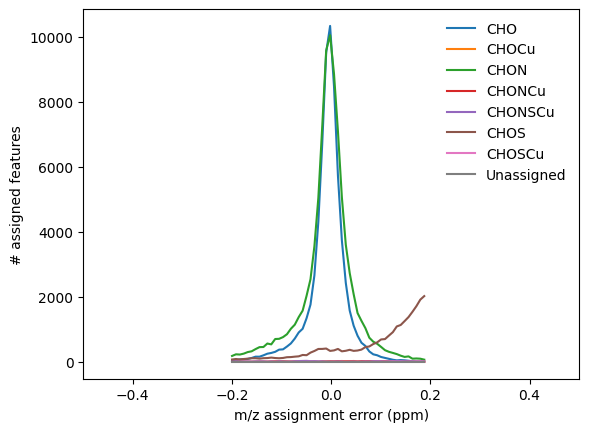

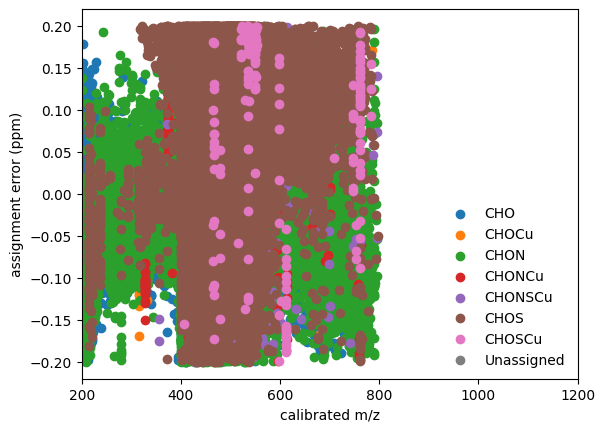

In [12]:
# plot assignment error distribution for full data set
pltMZerror(assignMolClass(data_df))

plt.show()

pltMZerror_pts(assignMolClass(data_df))

plt.show()

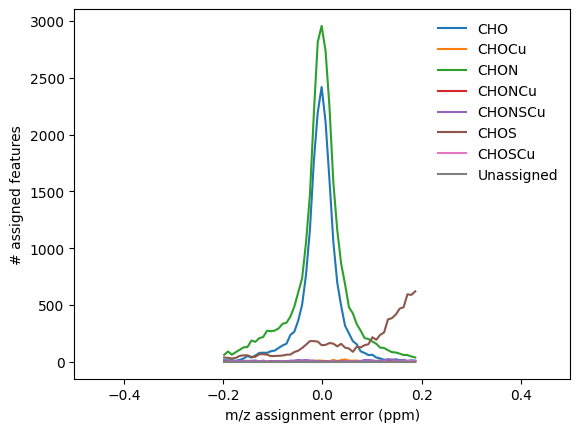

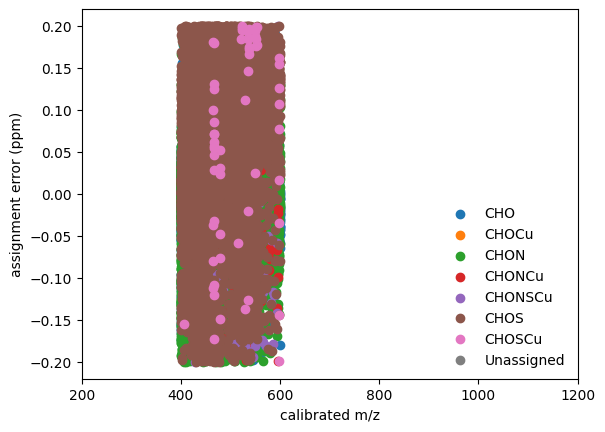

In [13]:
# plot assignment error dist for m/z 100 scans
pltMZerror(assignMolClass(mz100))

plt.show()

pltMZerror_pts(assignMolClass(mz100))

plt.show()

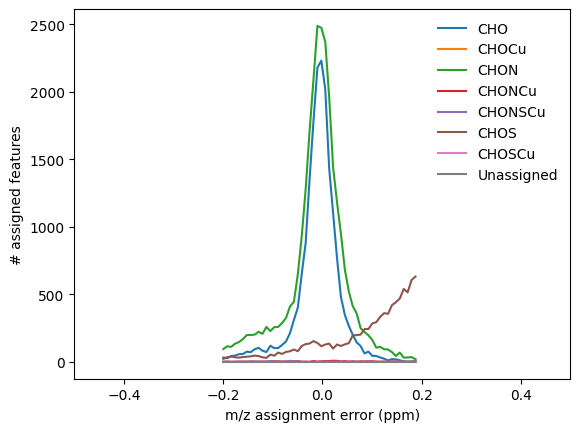

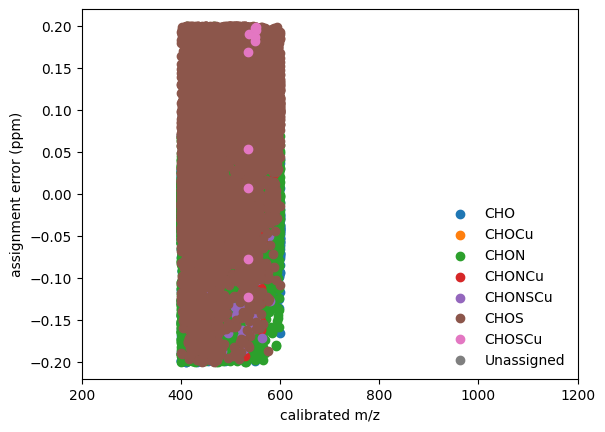

In [14]:
# plot assignment error dist for m/z 200 scans
pltMZerror(assignMolClass(mz200))

plt.show()

pltMZerror_pts(assignMolClass(mz200))

plt.show()

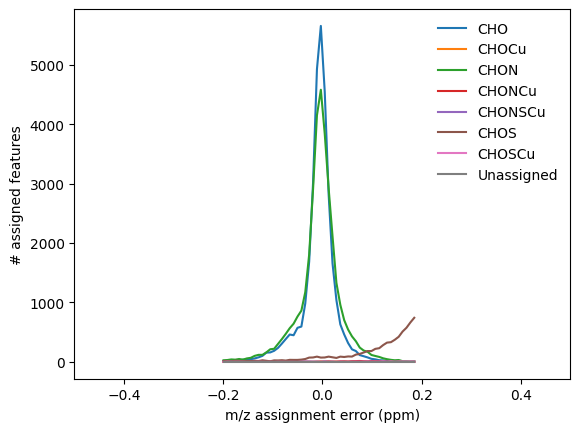

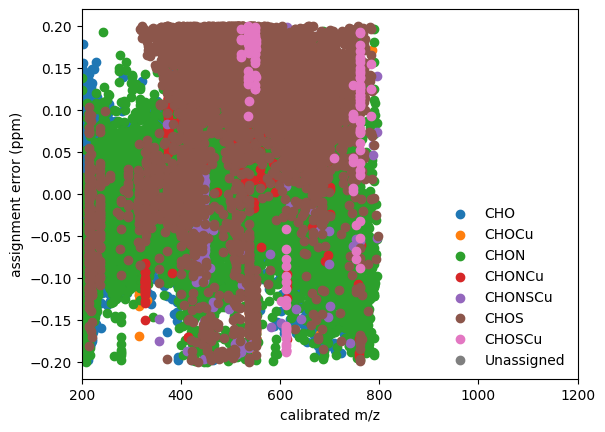

In [15]:
# plot assignment error dist for full m/z scans 
pltMZerror(assignMolClass(mzfull))

plt.show()

pltMZerror_pts(assignMolClass(mzfull))

plt.show()

In [16]:
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_200mz = mz200[~mz200['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-600 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('400-600 m/z, 200 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz200)[0], np.shape(assigned_200mz)[0], np.shape(assigned_200mz)[0] / np.shape(mz200)[0] * 100))
print('200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

print('\n\n')

unique_100mz = getUniqueFeatures(assigned_100mz)
unique_200mz = getUniqueFeatures(assigned_200mz)
unique_fullmz = getUniqueFeatures(assigned_fullmz)


400-600 m/z, 100 m/z windowing: 
98027 features total; 64443 assigned (65.7%)
400-600 m/z, 200 m/z windowing: 
83222 features total; 62051 assigned (74.6%)
200-800 m/z window (full scan): 
123096 features total; 86557 assigned (70.3%)



total # results: 64443
# unique results: 39929
total # results: 62051
# unique results: 33724
total # results: 86557
# unique results: 45000


In [17]:
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=400)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=600)]

assigned_200mz_456 = assigned_200mz[(assigned_200mz['m/z']>=400)]
assigned_200mz_456 = assigned_200mz_456[(assigned_200mz_456['m/z']<=600)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=400)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=600)]

mz100_456 = mz100[(mz100['m/z']>=400)]
mz100_456 = mz100_456[(mz100_456['m/z']<=600)]

mz200_456 = mz200[(mz200['m/z']>=400)]
mz200_456 = mz200_456[(mz200_456['m/z']<=600)]

mzfull_456 = mzfull[(mzfull['m/z']>=400)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=600)]

print('400-600 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-600 m/z, 200 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz200_456)[0], np.shape(assigned_200mz_456)[0], np.shape(assigned_200mz_456)[0] / np.shape(mz200_456)[0] * 100))
print('\n400-600 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))



400-600 m/z, 100 m/z windowing: 
98027 features total
64443 assigned (65.7%)

400-600 m/z, 200 m/z windowing: 
83222 features total
62051 assigned (74.6%)

400-600 m/z, full window: 
56613 features total
39919 assigned (70.5%)


In [18]:
# get unique features
unique_100mz_456 = getUniqueFeatures(assigned_100mz_456)
unique_200mz_456 = getUniqueFeatures(assigned_200mz_456)
unique_fullmz_456 = getUniqueFeatures(assigned_fullmz_456)

total # results: 64443
# unique results: 39929
total # results: 62051
# unique results: 33724
total # results: 39919
# unique results: 21489


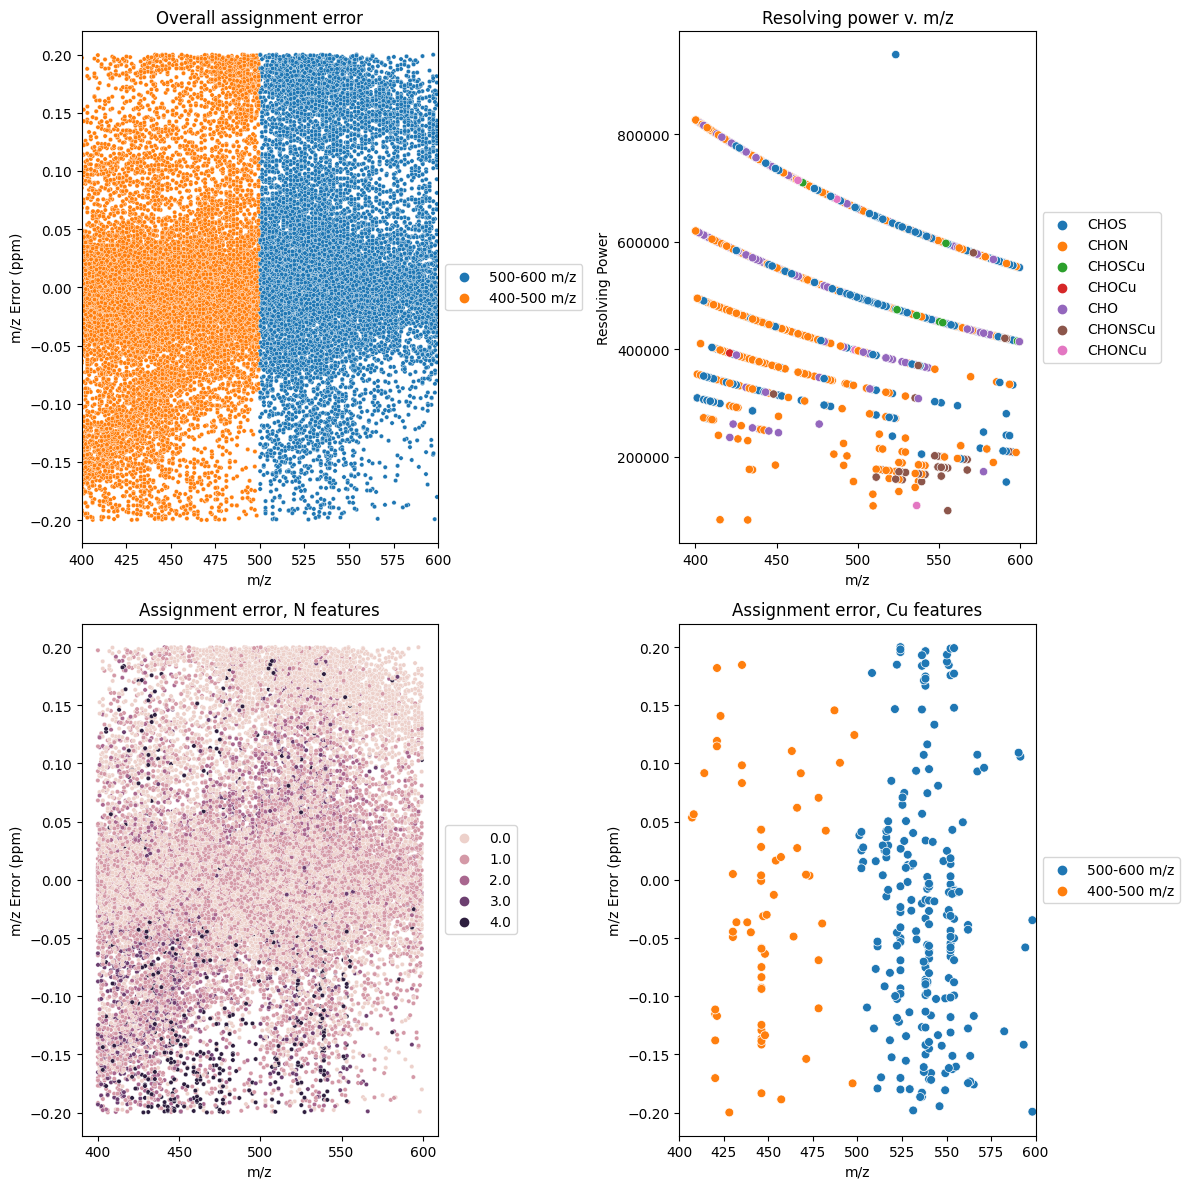

['20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw']


In [19]:
# 100 m/z window, error plots with blanks removed 
mask = ~unique_100mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_100mz_nb=unique_100mz_456[mask]
df = assignMolClass(unique_100mz_nb)

fig = plotUnique(df,ps=10)
plt.tight_layout()
plt.show()
print(unique_100mz_nb['file'].unique())

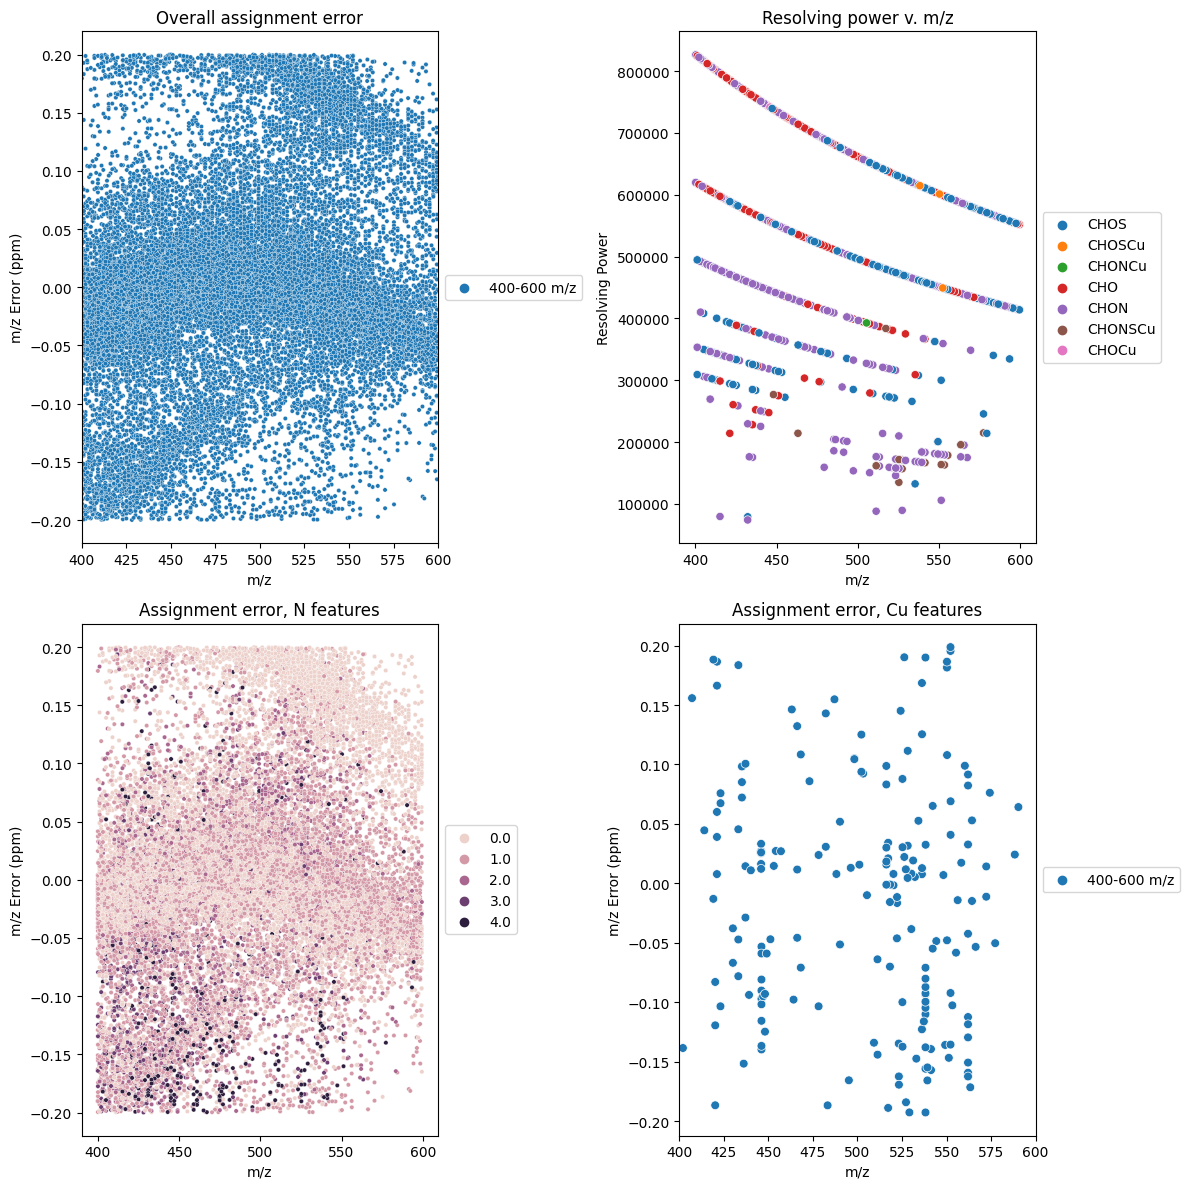

['20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw']


In [20]:
# 200 m/z window, error plots with blanks removed 

mask = ~unique_200mz_456['file'].str.contains('qh2o', case=False, na=False)
unique_200mz_nb=unique_200mz_456[mask]


fig = plotUnique(assignMolClass(unique_200mz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_200mz_nb['file'].unique())

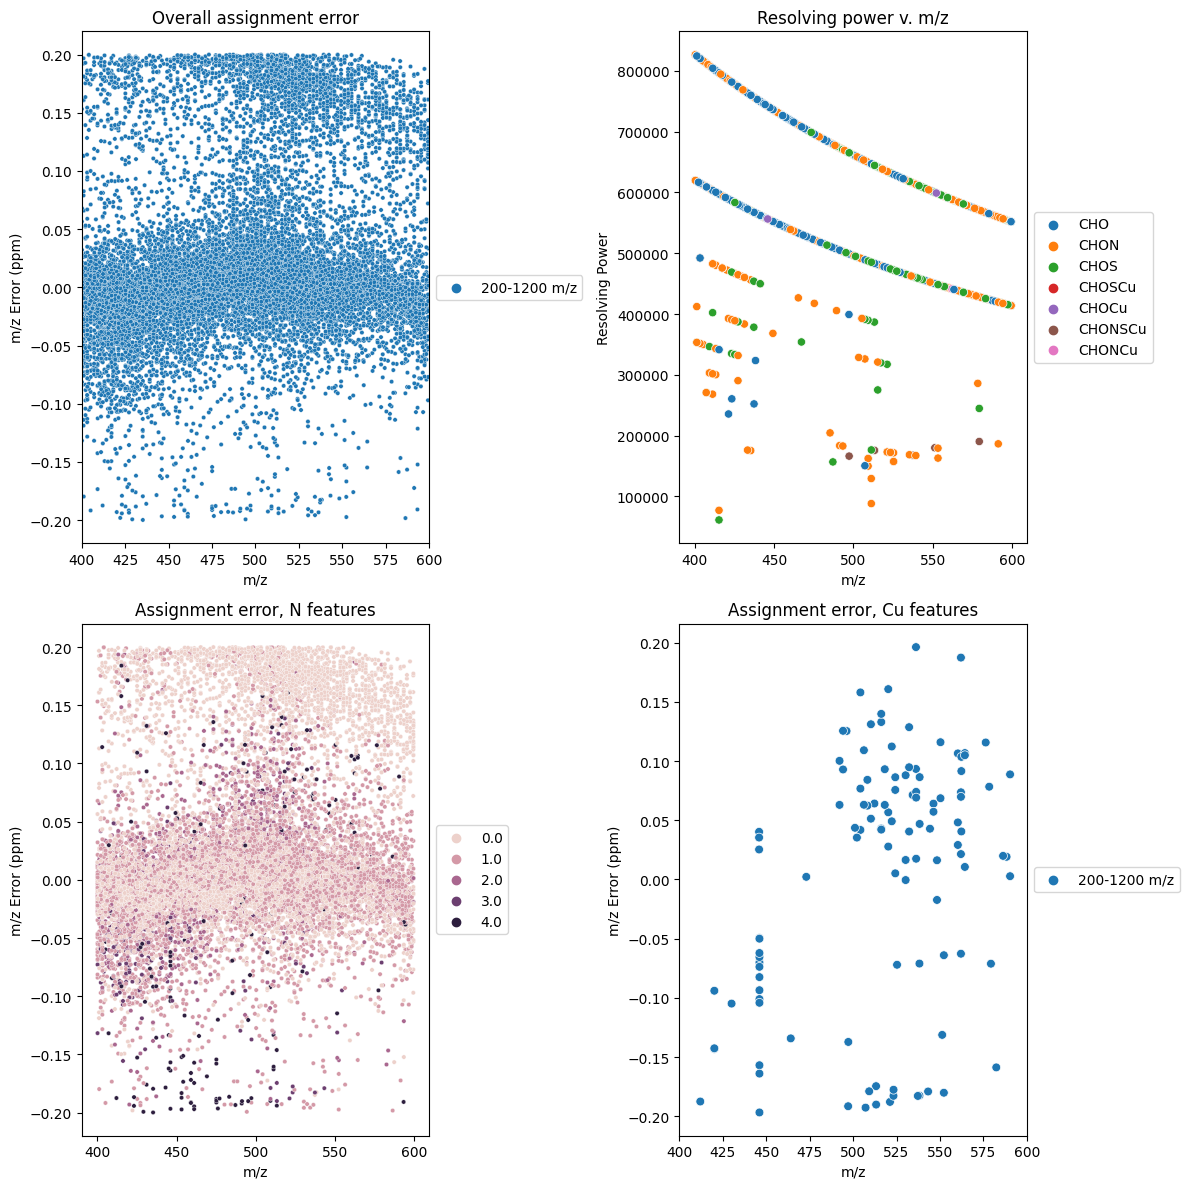

['20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw']


In [21]:
# full m/z window, error plots with blanks removed 

mask = ~unique_fullmz_456['file'].str.contains('qh2o', case=False, na=False)
unique_fullmz_nb=unique_fullmz_456[mask]


fig = plotUnique(assignMolClass(unique_fullmz_nb),ps=10)
plt.tight_layout()
plt.show()
plt.close('all')

print(unique_fullmz_nb['file'].unique())

In [22]:
# create 200 m/z blank files from 100 m/z blank files (did not collect 200 m/z blank files)

blank_files = [f for f in rawfiles if 'qh2o' in f]

blank_data = []

for f in blank_files:

    if 'fullmz' not in f:
        
        temp = data_df[data_df['file'] == f] 

        blank_data.append(temp)

blanks_df = pd.concat(blank_data)

rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
rep1_temp = rep1_temp[rep1_temp['m/z'] <= 600]
rep1_temp['file'] = 'mz200_400_600_blnk'
rep1_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])

#rep1_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep1_temp = rep1_temp[rep1_temp['m/z'] >= 600]
#rep1_temp['file'] = 'mz200_600_800_blnk'
#rep1_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep1_temp])


rep2_temp = blanks_df[blanks_df['file'].str.contains('rep2')]
rep2_temp = rep2_temp[rep2_temp['m/z'] <= 600]
rep2_temp['file'] = 'mz200_400_600_blnk_rep2'
rep2_temp['m/z window'] = '400-600 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

#rep2_temp = blanks_df[~blanks_df['file'].str.contains('rep2')]
#rep2_temp = rep2_temp[rep2_temp['m/z'] >= 600]
#rep2_temp['file'] = 'mz200_600_800_blnk_rep2'
#rep2_temp['m/z window'] = '600-800 m/z'

blanks_df = pd.concat([blanks_df,rep2_temp])

print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())



['20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw' 'mz200_400_600_blnk'
 'mz200_400_600_blnk_rep2']
['500-600 m/z' '400-500 m/z' '400-600 m/z']


In [23]:
# add 200 m/z blank data to master df

mz200_blanks = blanks_df[blanks_df['m/z window'] == '400-600 m/z']
data_df = pd.concat([data_df, mz200_blanks])

for f in data_df['file'].unique():
    print(f)




20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_400_600_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw
20221103_LBA_Boiteau_Zorbax3p5_spring_500_600_rep2.raw
mz200_400_600_blnk
mz200_400_600_blnk_rep2


In [24]:
# add fullmz blanks to blanks df
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw' ]])
blanks_df = pd.concat([blanks_df, data_df[data_df['file'] =='20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw' ]])

print(blanks_df['m/z window'].unique())

['500-600 m/z' '400-500 m/z' '400-600 m/z' '200-1200 m/z']


In [25]:
# add column with blank file identity to use in blank subtraction
df_backup = data_df
df_backup.to_csv("/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/spring-max600mz_backup.csv")

data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window

    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]


        temp2['blank file'] = btemp2['file'].iloc[0]

        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2


print(data_df['blank file'].unique())

['20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500_rep2.raw'
 'mz200_400_600_blnk'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600_rep2.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_fullmz.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'
 '20221103_LBA_Boiteau_Zorbax3p5_qh2o_500_600.raw'
 'mz200_400_600_blnk_rep2']


In [26]:
def blankSubtract(df, blnkthresh = 0.9):
    
    holder = []
    for file in df['file'].unique():
        
        #if file == 
        sub = df[df['file'] == file]

        blkf = sub['blank file'].iloc[0]


        sub[sub[file]== np.nan] = 0

        nom = sub[file]
        den = sub[blkf]

        nom = nom.replace(np.nan,0)
        den = den.replace(np.nan,1)

        if file != blkf:
            nom = nom
        elif file == blkf:
            nom = nom * (blnkthresh*0.8)

        sub['blank subtract'] = nom/den
        holder.append(sub)
    df_end = pd.concat(holder)
    df_end = df_end[df_end['blank subtract'] > blnkthresh]
    return df_end

In [27]:
df_unique = getUniqueFeatures(data_df)


total # results: 344929
# unique results: 66279


In [28]:


df_bs = blankSubtract(df_unique, blnkthresh=0.3)


(48243, 56)


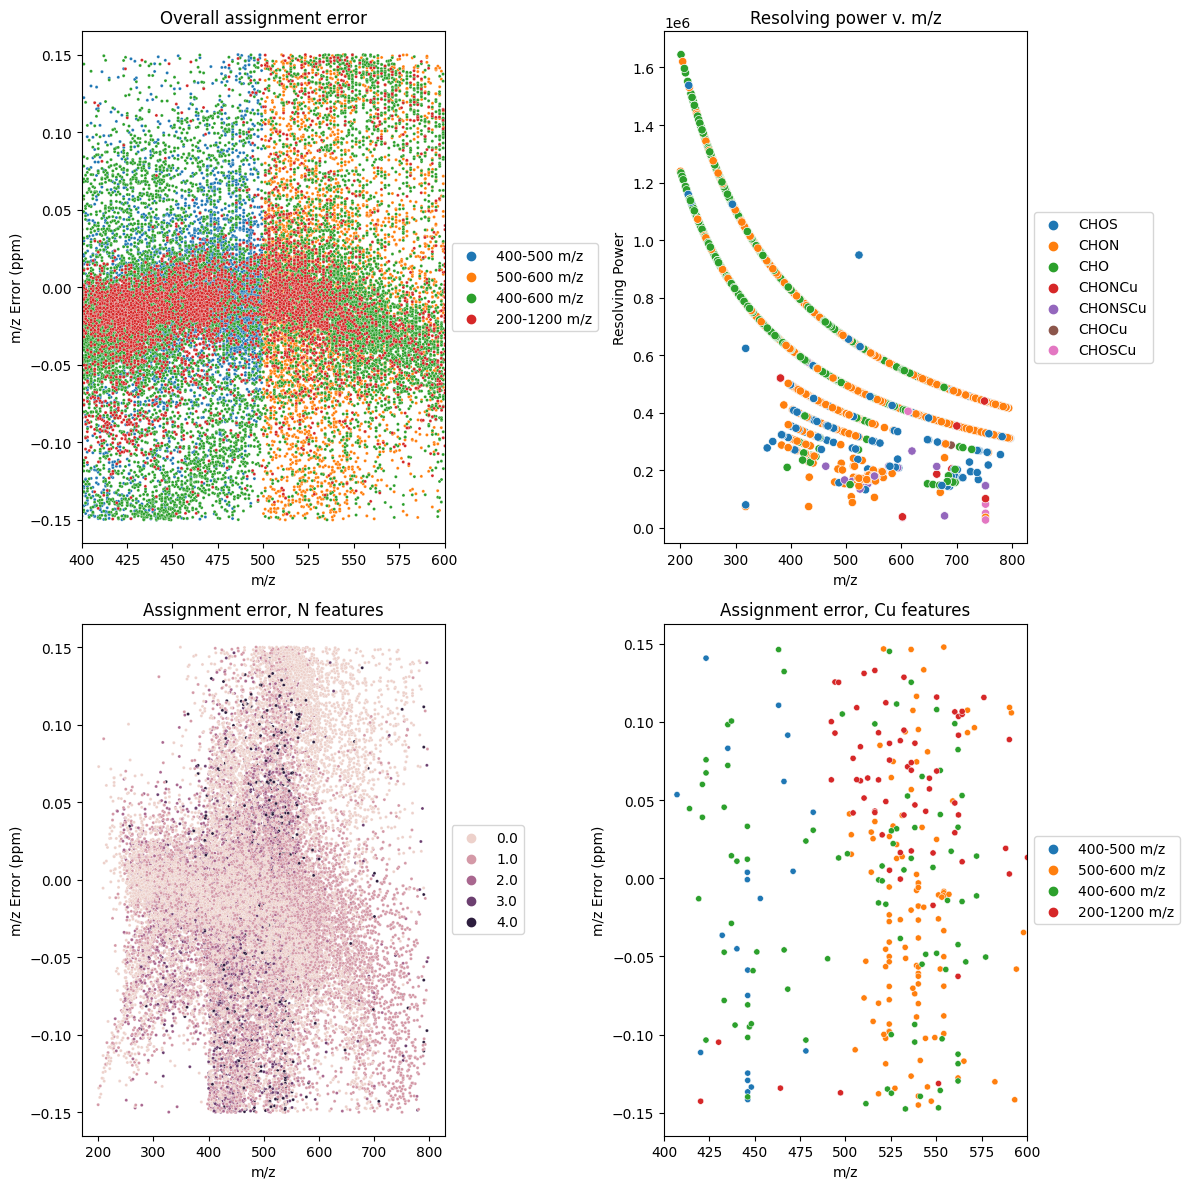

In [30]:
temp = df_bs[abs(df_bs['m/z Error (ppm)'])<0.15]
print(np.shape(temp))
fig = plotUnique(assignMolClass(pd.concat([temp[temp['m/z window']== '400-500 m/z'], temp[temp['m/z window']=='500-600 m/z'], temp[temp['m/z window']=='400-600 m/z'], temp[temp['m/z window']=='200-1200 m/z']])),ps=5)

plt.tight_layout()
plt.show()
plt.close('all')

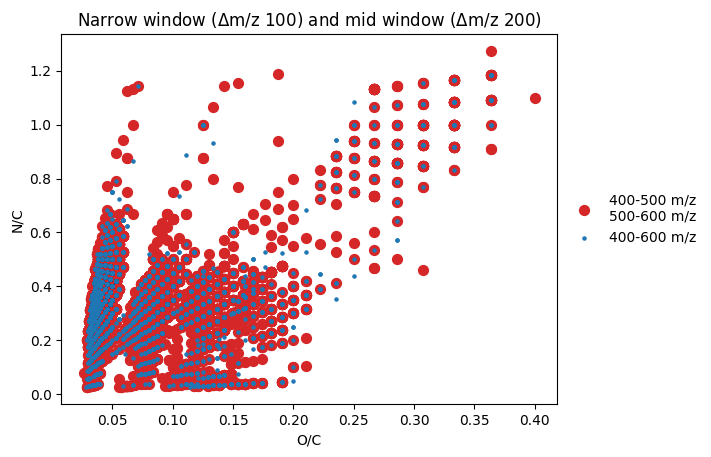

In [31]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#sns.scatterplot(x='N/C',y='O/C', hue='m/z', data=df, ax=ax,s=50)
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


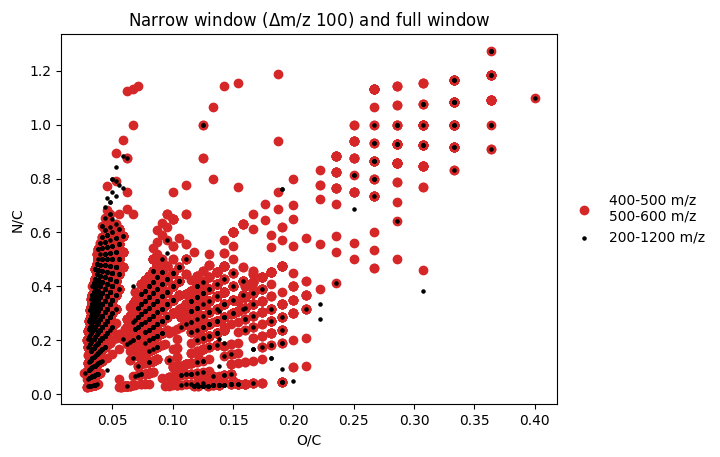

In [32]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs
df2 = mz200_bs
df3 = mzfull_bs
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
#ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='400-600 m/z') #s=df2['S/N'],
ax.scatter(x=df3['N/C'],y=df3['O/C'],c='black',s=5,label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()


In [33]:
temp = df_bs[df_bs['m/z'] >= 400]
temp = temp[temp['m/z']<=600]

temp['m/z Window Size'] = temp.Index

for i in range(len(temp['m/z window'])):

    w = temp['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        temp['m/z Window Size'].iloc[i] = '1000 m/z'

In [91]:
temp['m/z window'].unique()

array(['400-600 m/z', '500-600 m/z', '200-1200 m/z', '400-500 m/z'],
      dtype=object)

In [34]:
mz100_contains_cu = mz100_bs[(mz100_bs['Cu'] == 1) | (mz100_bs['65Cu'] == 1)]
print(np.shape(mz100_contains_cu))
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz100_cu_limited_err))

mz200_contains_cu = mz200_bs[(mz200_bs['Cu'] == 1) | (mz200_bs['65Cu'] == 1)]
print(np.shape(mz200_contains_cu))
mz200_cu_limited_err = mz200_contains_cu[abs(mz200_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mz200_cu_limited_err))

mzfull_contains_cu = mzfull_bs[(mzfull_bs['Cu'] == 1) | (mzfull_bs['65Cu'] == 1)]
print(np.shape(mzfull_contains_cu))
mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.2]
print(np.shape(mzfull_cu_limited_err))


(320, 56)
(320, 56)
(254, 56)
(254, 56)
(137, 56)
(137, 56)


In [35]:
temp = temp[temp['Cu'] == 1]

temp['overlap'] = temp.Index

for i in range(len(temp['Molecular Formula'])):

    mf = temp['Molecular Formula'].iloc[i]

    if (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        temp['overlap'].iloc[i] = 'n'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf not in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nw'

    elif (mf not in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nm'

    elif (mf in mzfull_contains_cu['Molecular Formula'].values) and (mf in mz200_contains_cu['Molecular Formula'].values):
        
        temp['overlap'].iloc[i] = 'nmw'



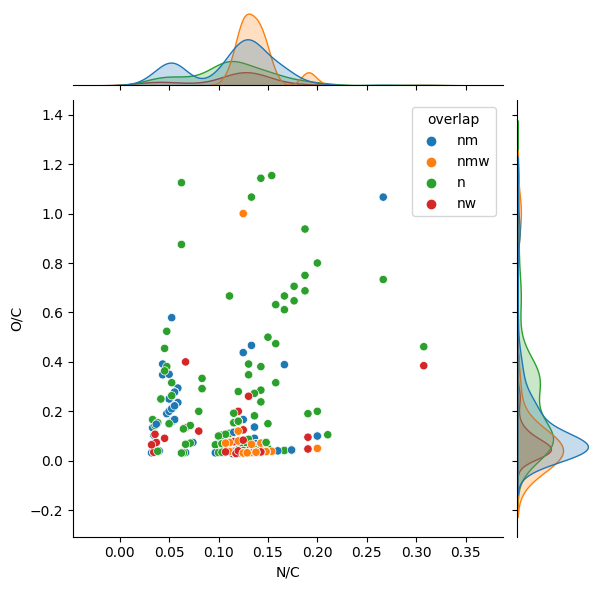

In [114]:


sns.jointplot(data=temp, x='N/C',y='O/C', hue='overlap')


In [36]:
print(np.shape(mzfull_cu_limited_err))
print(np.shape(mz100_cu_limited_err))

combo = pd.concat([mz100_cu_limited_err, mzfull_cu_limited_err])

combo['m/z Window Size'] = combo.Index

for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '400-500 m/z') or (w == '500-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '100 m/z'

    elif (w == '400-600 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

combo['m/z Window Size'].unique()

(137, 56)
(320, 56)


array(['100 m/z', '1000 m/z'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


138       27.923678
1499       3.781423
2831     254.315196
3330      15.668285
4374       2.225811
            ...    
66108      2.074947
66126     10.508848
66129      5.741657
66135     30.328003
66177     11.848192
Name: S/N Norm, Length: 320, dtype: float64
138       27.923678
1499       3.781423
2831     254.315196
3330      15.668285
4374       2.225811
            ...    
66108      2.074947
66126     10.508848
66129      5.741657
66135     30.328003
66177     11.848192
Name: S/N Norm, Length: 320, dtype: float64


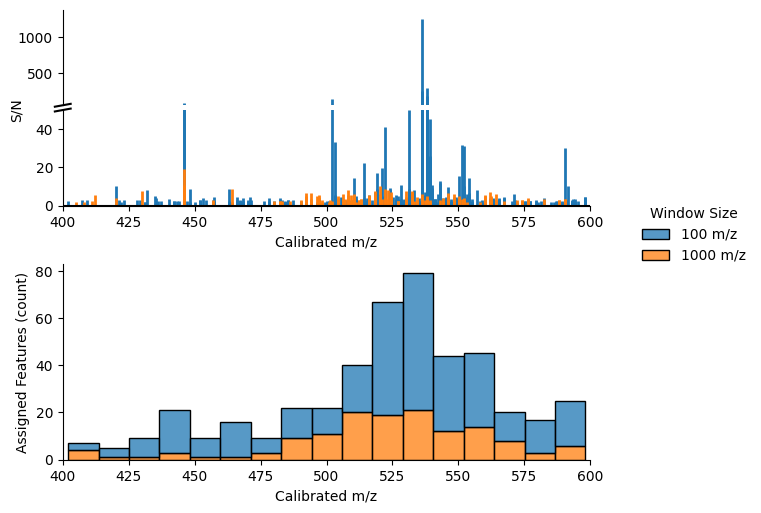

In [54]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0], hspace = .05)

ax1_t = plt.subplot(gs1[0])
ax1_t = plot_ms(df1=mz100_cu_limited_err,  df2=mzfull_cu_limited_err, start_mz=400, end_mz=600,ax_ms=ax1_t)
ax1_b = plt.subplot(gs1[1])
ax1_b = plot_ms(df1=mz100_cu_limited_err,  df2=mzfull_cu_limited_err, start_mz=400, end_mz=600,ax_ms=ax1_b)
ax1_t.set_ylim(bottom=50)   
ax1_b.set_ylim(0,50)
ax1_t.set_xlim(400,600)
ax1_b.set_xlim(400,600)
ax1_t.set_xlabel(None)

sns.despine(ax=ax1_b)
sns.despine(ax=ax1_t, bottom=True)

ax = ax1_t
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.tick_params(left=True, bottom=False)
ax.set_ylabel(None)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax1b = ax1_b
kwargs.update(transform=ax1b.transAxes)  # switch to the bottom axes
ax1b.set_ylabel(None)
ax1b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1_b.legend_.remove()
ax1b.get_shared_x_axes().join(ax1b, ax)
ax.set_xticklabels([])
ax1b.text(-0.1, 1., 'S/N', va='center', rotation='vertical',transform=ax1b.transAxes)


ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

In [38]:
for n in mzfull_cu_limited_err['65Cu']: 
    if n >0 :
        print(n)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


30546    2.839287
Name: S/N Norm, dtype: float64
30546    2.839287
Name: S/N Norm, dtype: float64


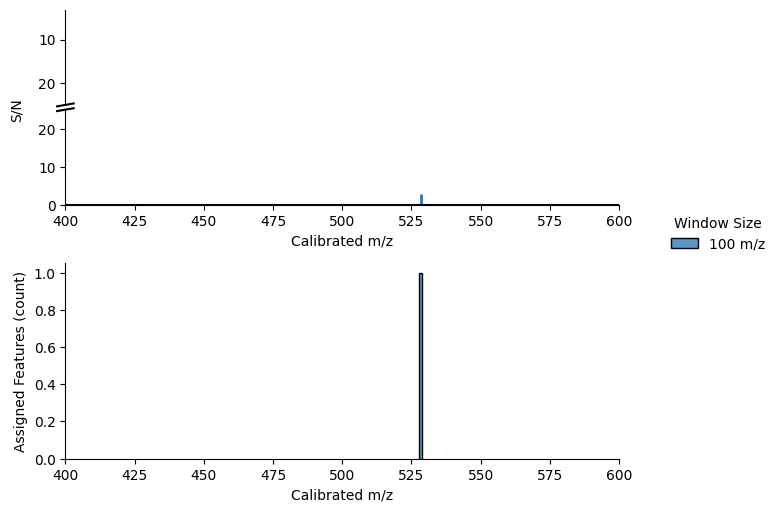

In [39]:
import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.02)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[0], hspace = .05)

ax1_t = plt.subplot(gs1[0])
ax1_t = plot_ms(df1=mz100_cu_limited_err[mz100_cu_limited_err['65Cu']==1],  df2=mzfull_cu_limited_err[mzfull_cu_limited_err['65Cu']==1], start_mz=400, end_mz=600,ax_ms=ax1_t)
ax1_b = plt.subplot(gs1[1])
ax1_b = plot_ms(df1=mz100_cu_limited_err[mz100_cu_limited_err['65Cu']==1],  df2=mzfull_cu_limited_err[mzfull_cu_limited_err['65Cu']==1], start_mz=400, end_mz=600,ax_ms=ax1_b)
ax1_t.set_ylim(bottom=25)   
ax1_b.set_ylim(0,25)
ax1_t.set_xlim(400,600)
ax1_b.set_xlim(400,600)
ax1_t.set_xlabel(None)

sns.despine(ax=ax1_b)
sns.despine(ax=ax1_t, bottom=True)

ax = ax1_t
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.tick_params(left=True, bottom=False)
ax.set_ylabel(None)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax1b = ax1_b
kwargs.update(transform=ax1b.transAxes)  # switch to the bottom axes
ax1b.set_ylabel(None)
ax1b.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1_b.legend_.remove()
ax1b.get_shared_x_axes().join(ax1b, ax)
ax.set_xticklabels([])
ax1b.text(-0.1, 1., 'S/N', va='center', rotation='vertical',transform=ax1b.transAxes)


ax2 = plt.subplot(gs2[0])

sns.despine(ax=ax2)

sns.histplot(combo[combo['65Cu']==1], x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2)
ax2.set_ylabel('Assigned Features (count)')
ax2.set_xlim(400,600)
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(1.02, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

plt.show()

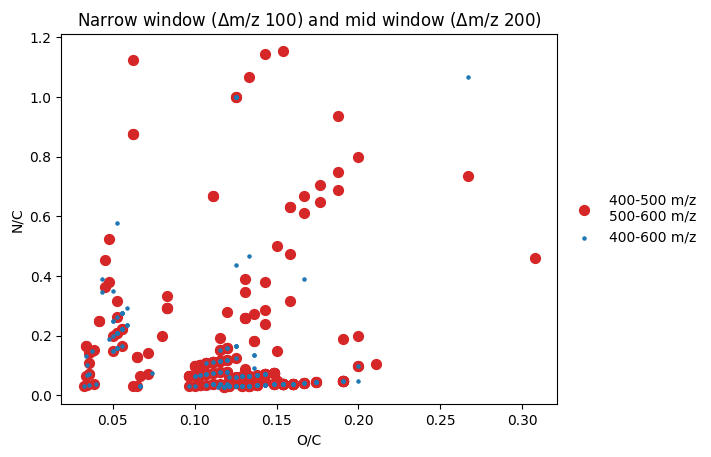

In [88]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs[mz100_bs['Cu'] == 1]
df2 = mz200_bs[mz200_bs['Cu'] == 1]
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='C0',s=5,label='400-600 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and mid window ($\Delta$m/z 200)')
plt.show()


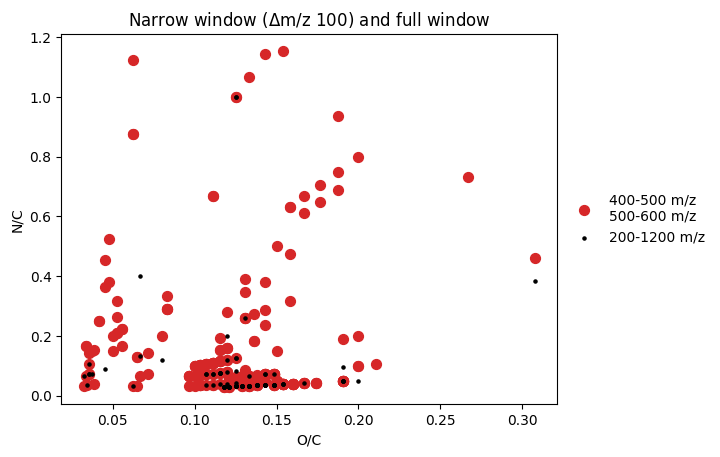

In [39]:
mz100_bs = df_bs[(df_bs['m/z window'] == '400-500 m/z') | (df_bs['m/z window'] == '500-600 m/z')]

mz200_bs = df_bs[(df_bs['m/z window'] == '400-600 m/z')]

mzfull_bs = df_bs[(df_bs['m/z window'] == '200-1200 m/z')]
mzfull_bs = mzfull_bs[(mzfull_bs['m/z']>=400) & (mzfull_bs['m/z']<= 600)]

df = mz100_bs[mz100_bs['Cu'] == 1]
df2 = mzfull_bs[mzfull_bs['Cu'] == 1]
fig, ax = plt.subplots()
ax.scatter(x=df['N/C'],y=df['O/C'],c='C3',s=50,label='400-500 m/z\n500-600 m/z')#,s=df['S/N']
ax.scatter(x=df2['N/C'],y=df2['O/C'],c='black',s=5,label='200-1200 m/z') #s=df2['S/N'],
#ax.scatter(x=df3['N/C'],y=df3['O/C'],c='C5',label='200-1200 m/z') #s=df3['S/N']
ax.set(xlabel='O/C',ylabel='N/C')
#ax.set_xlim(0,1.2)
#ax.set_ylim(0,0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0,0.5), loc='center left')
plt.title(r'Narrow window ($\Delta$m/z 100) and full window')
plt.show()

In [44]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}
mz100_cu_limited_err = mz100_contains_cu[abs(mz100_contains_cu['m/z Error (ppm)']) < 0.1]
mz100_EICdic = {}
for mz,file,mf in zip(mz100_cu_limited_err['m/z'],mz100_cu_limited_err['file'],mz100_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']    
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    mz100_EICdic[mf]=EIC[0][mz]
    #mz100_EICdic[mz]={'eic':EIC[0][mz],'formula':mf}



In [45]:
#data.master_data_holder['20221103_LBA_Boiteau_Zorbax3p5_spring_400_500_rep2.raw'] #[file]={'parser': parser}

mzfull_cu_limited_err = mzfull_contains_cu[abs(mzfull_contains_cu['m/z Error (ppm)']) < 0.1]
fullmz_EICdic = {}
for mz,file,mf in zip(mzfull_cu_limited_err['m/z'],mzfull_cu_limited_err['file'],mzfull_cu_limited_err['Molecular Formula']):
    
    parser = data.master_data_holder[file]['parser']
 
    EIC=parser.get_eics(target_mzs=[mz],tic_data={},peak_detection=False,smooth=False)
    fullmz_EICdic[mf]=EIC[0][mz]


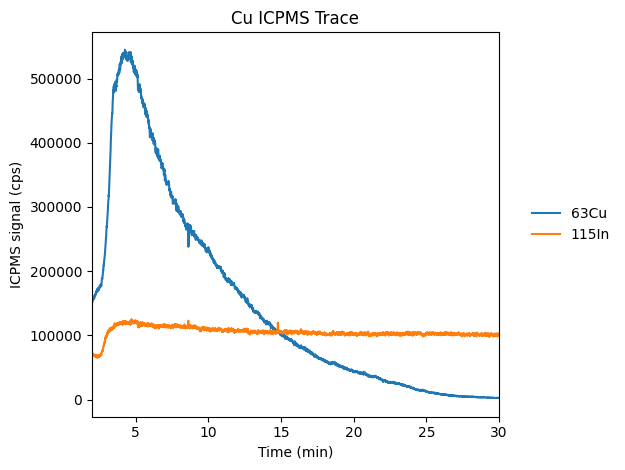

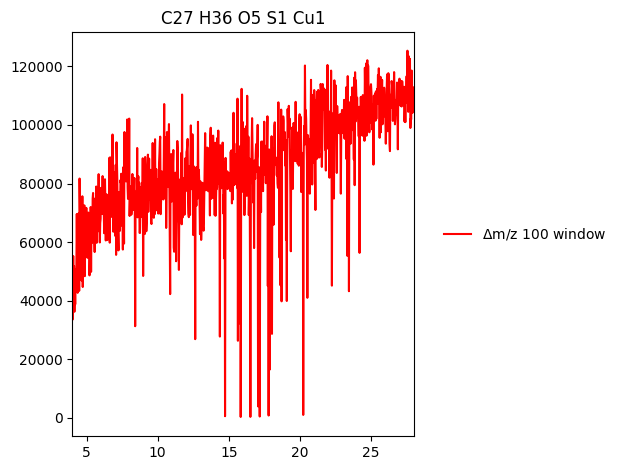

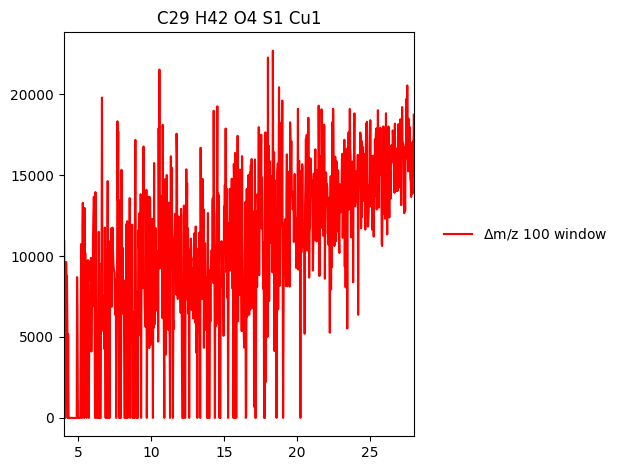

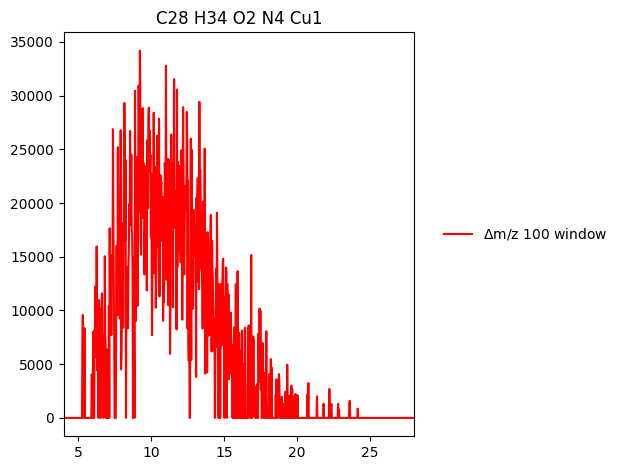

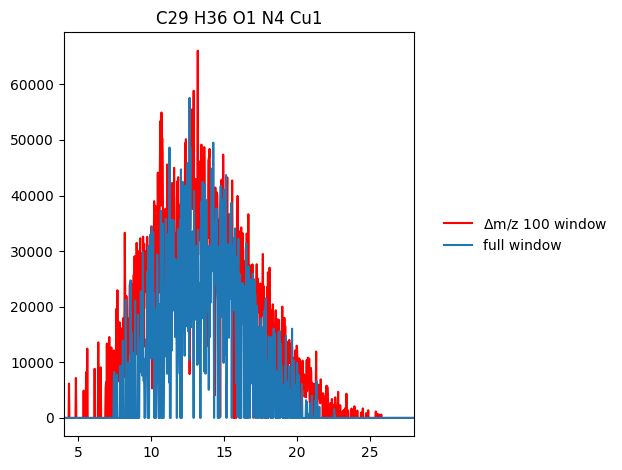

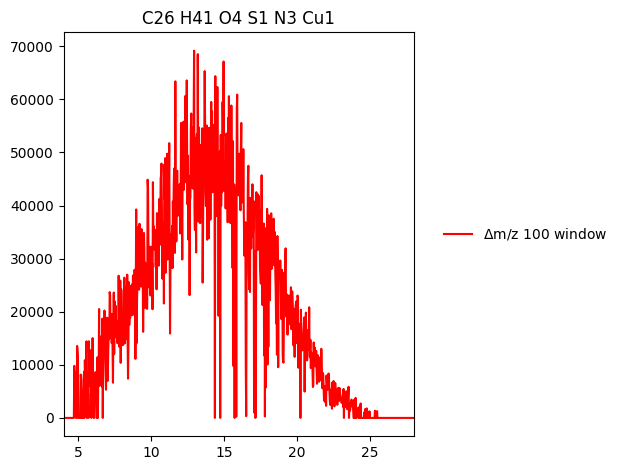

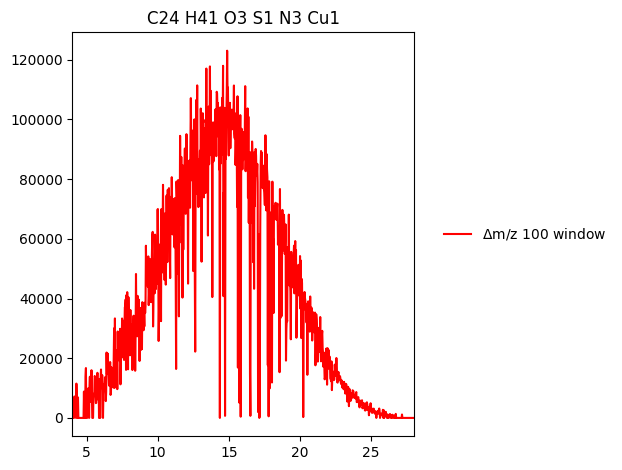

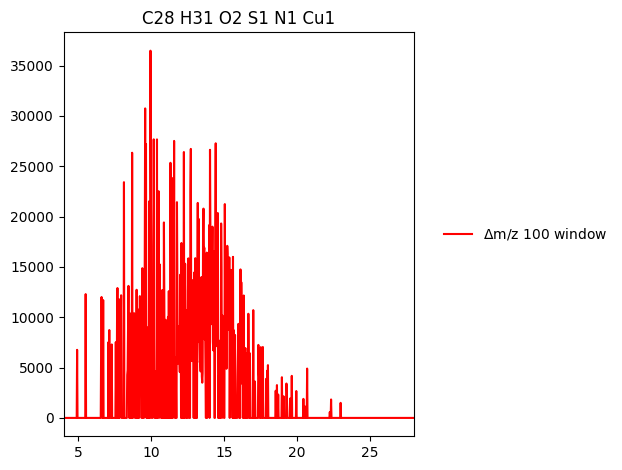

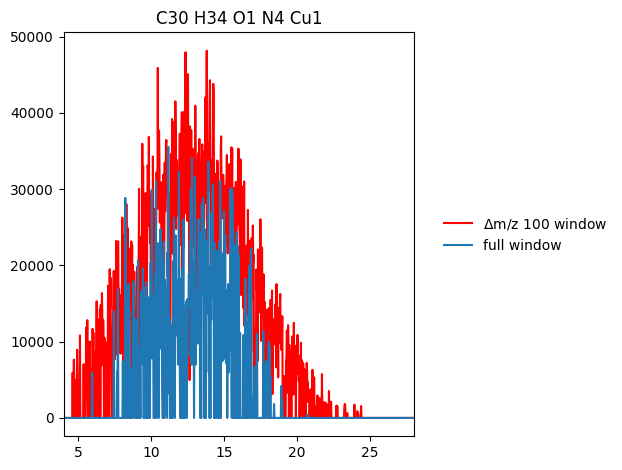

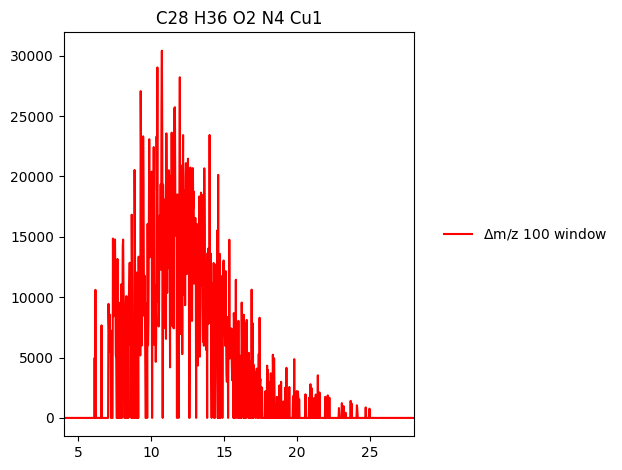

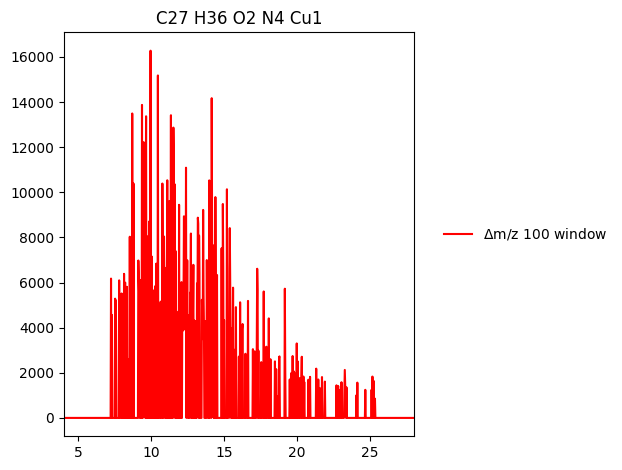

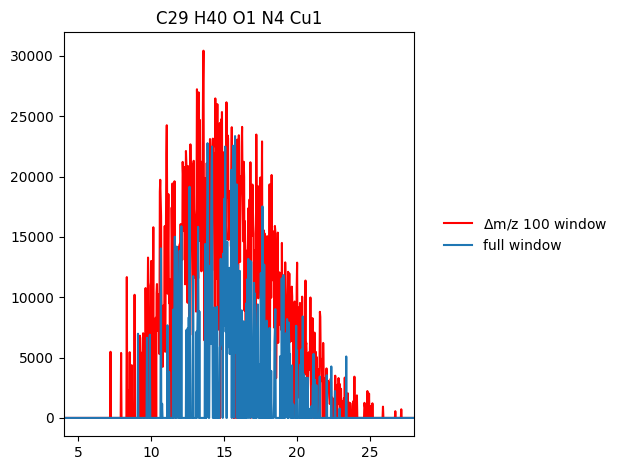

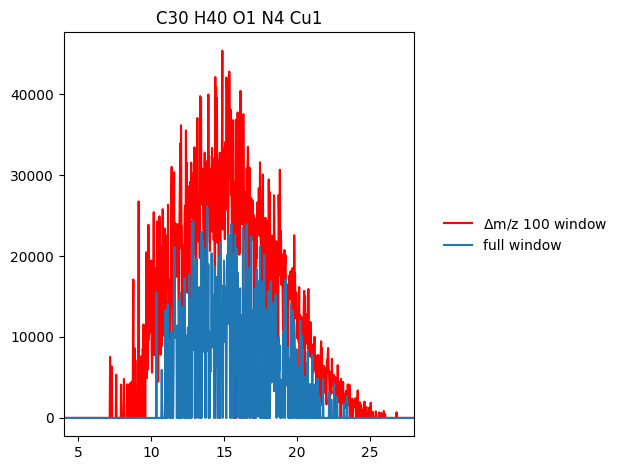

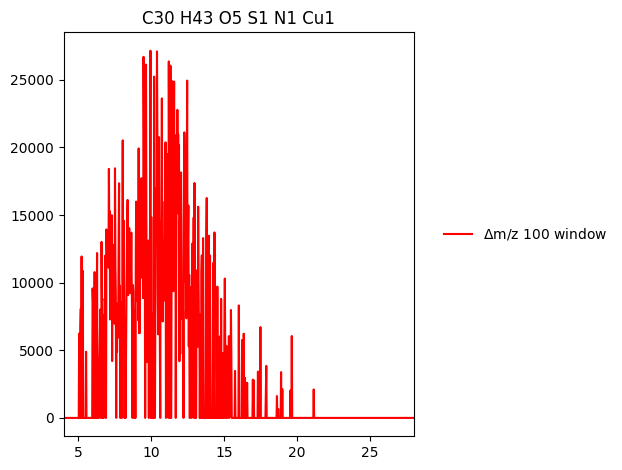

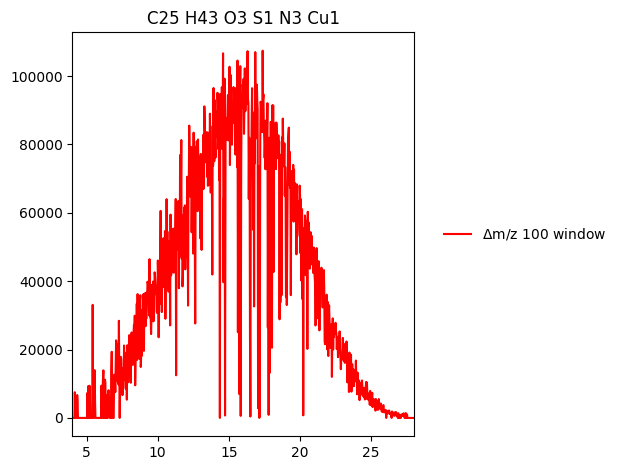

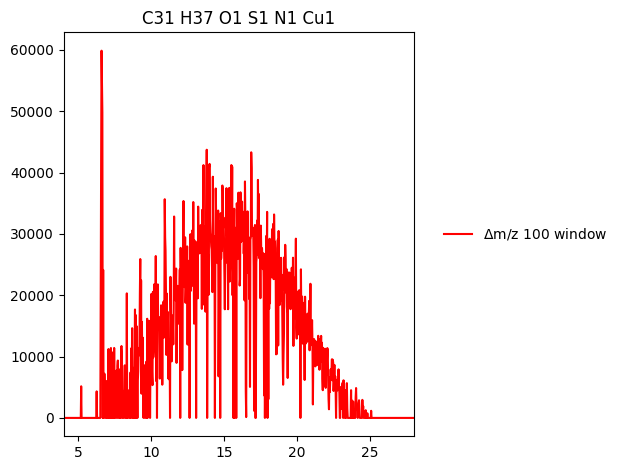

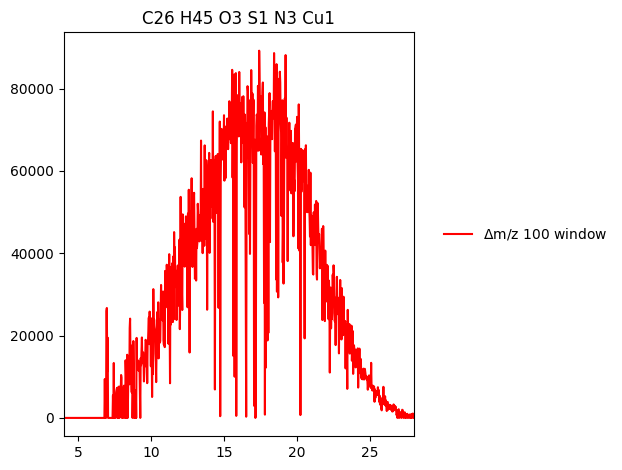

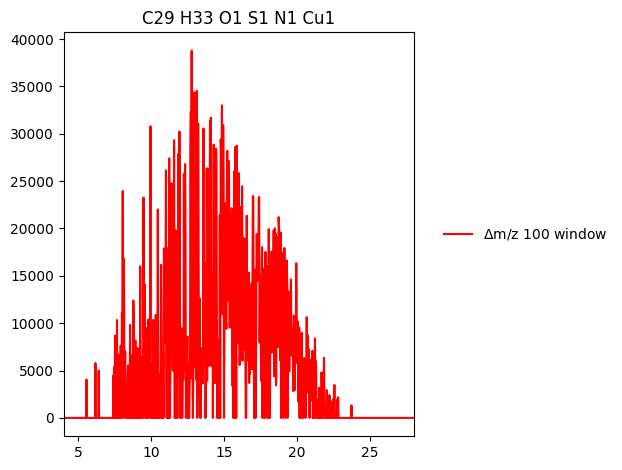

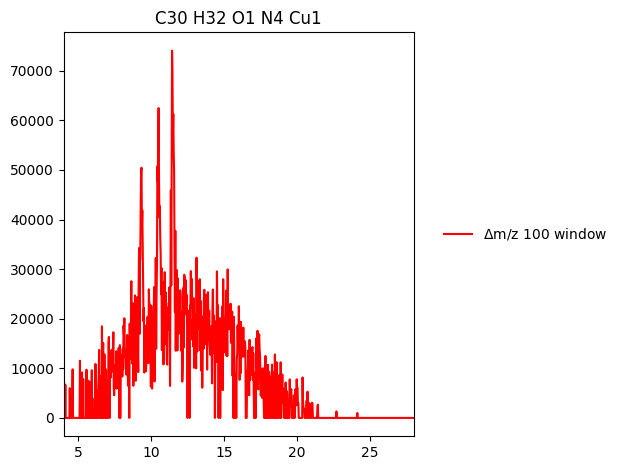

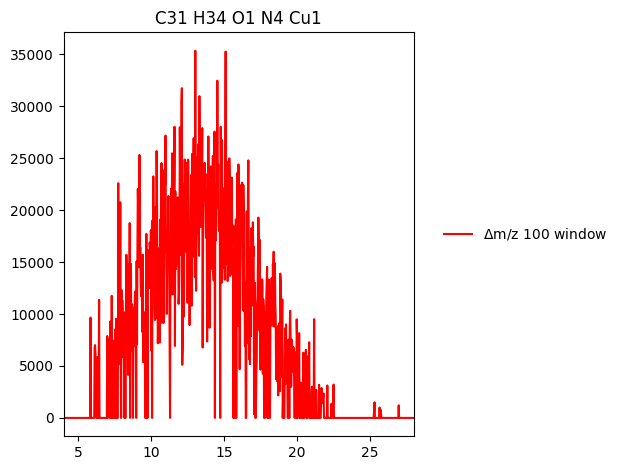

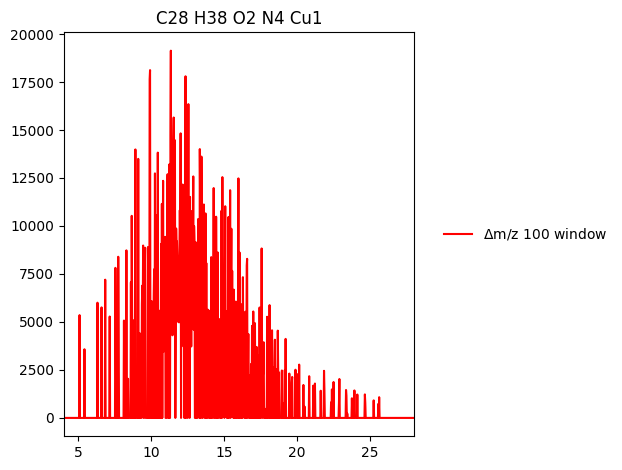

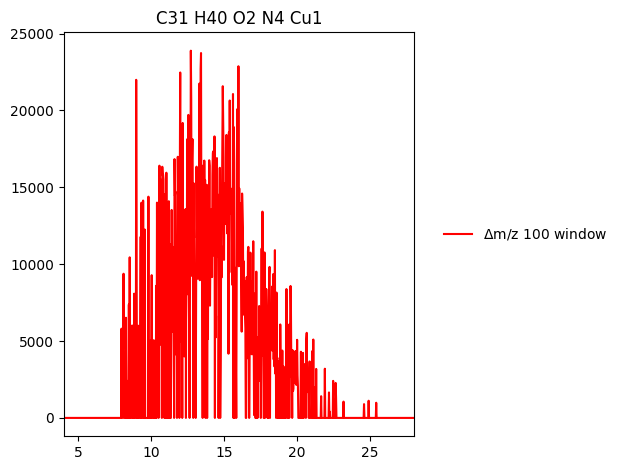

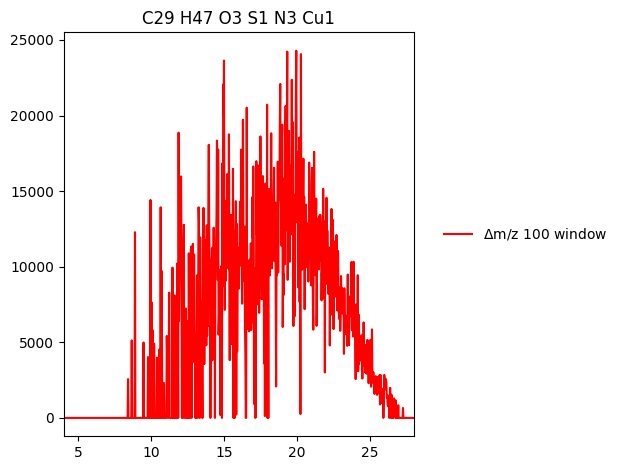

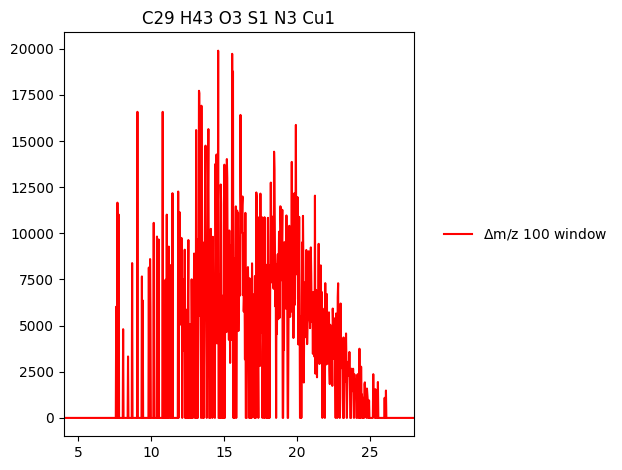

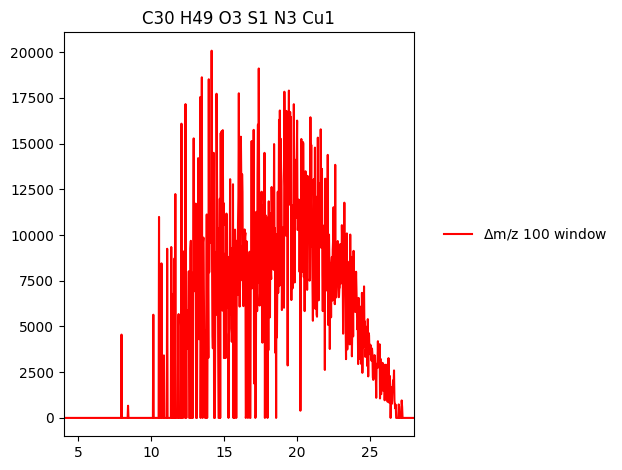

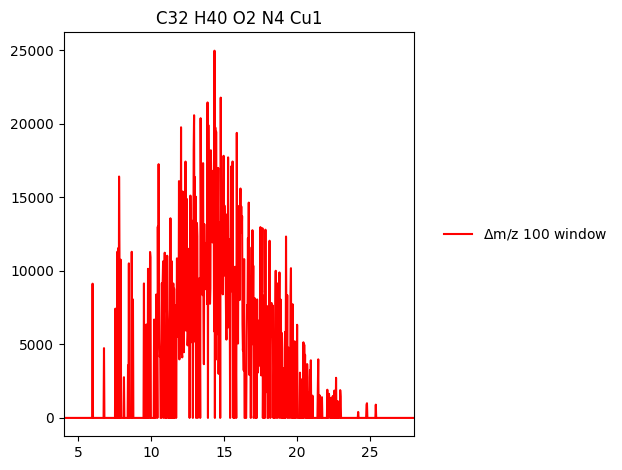

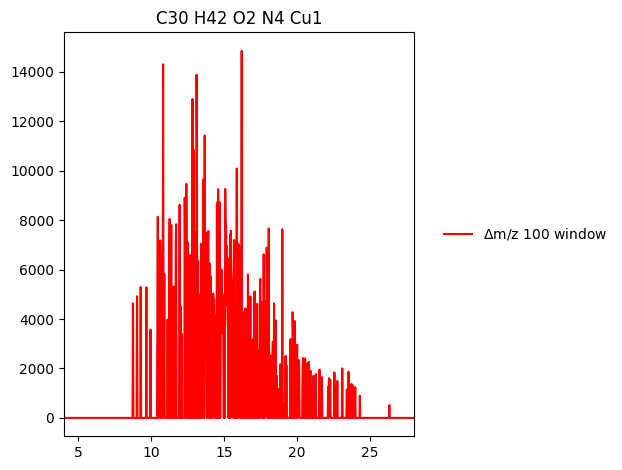

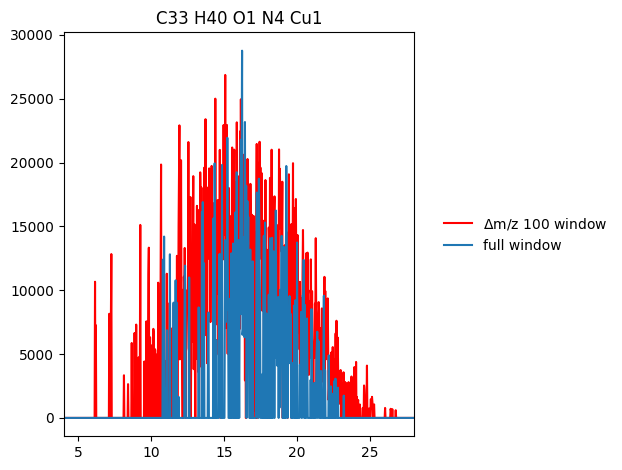

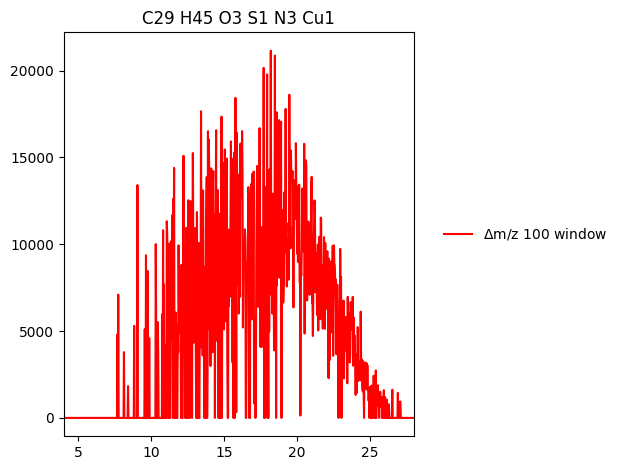

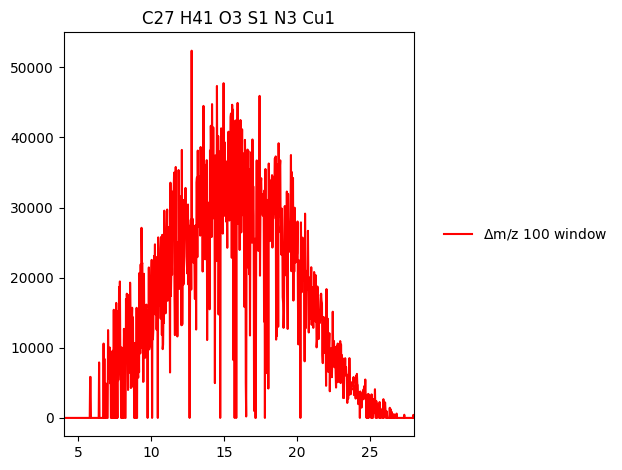

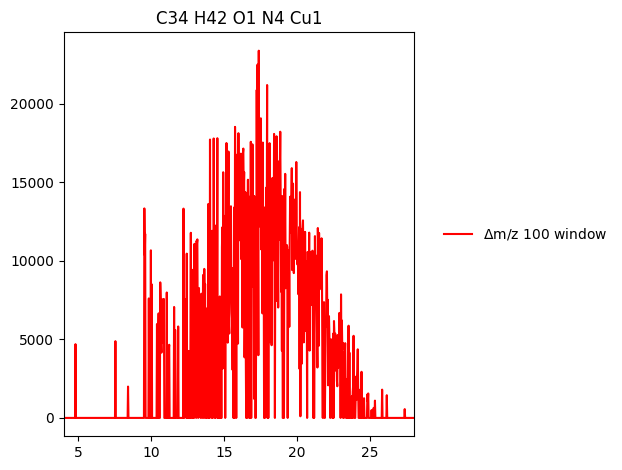

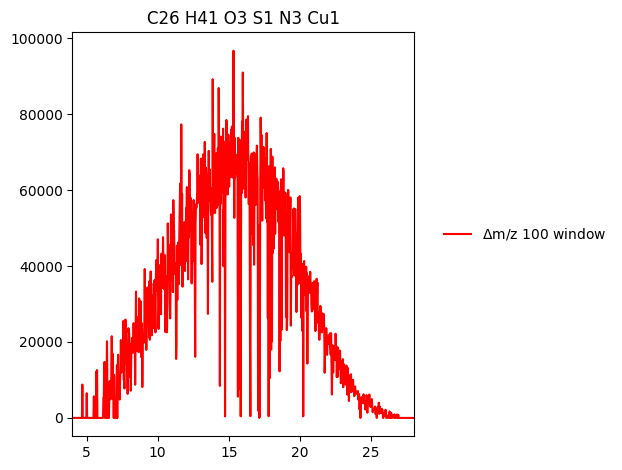

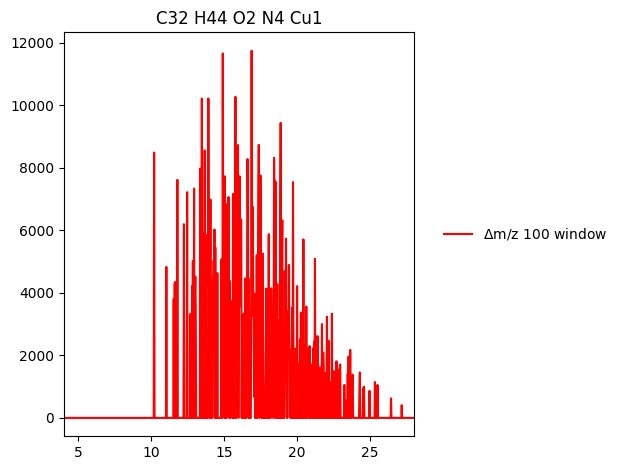

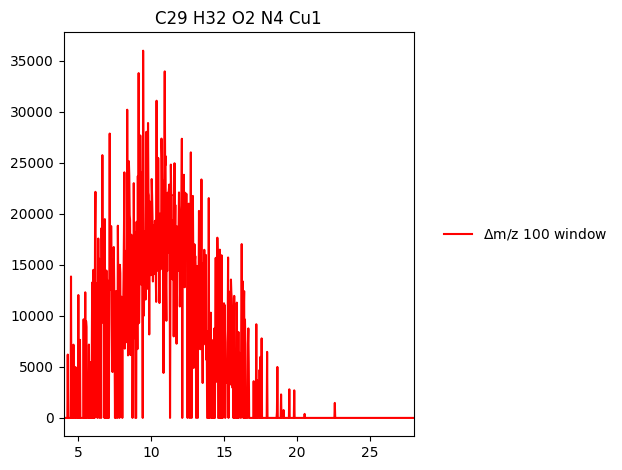

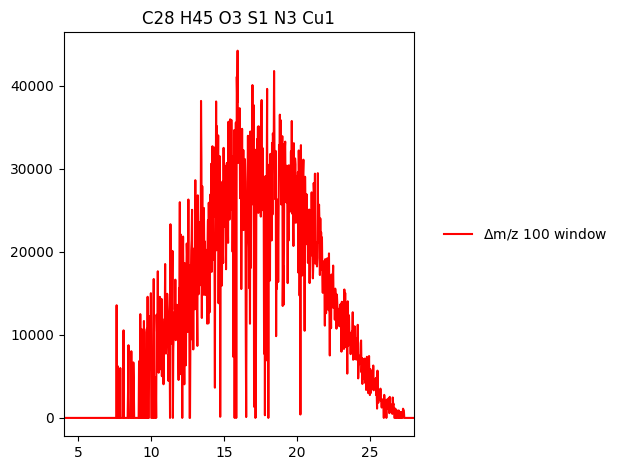

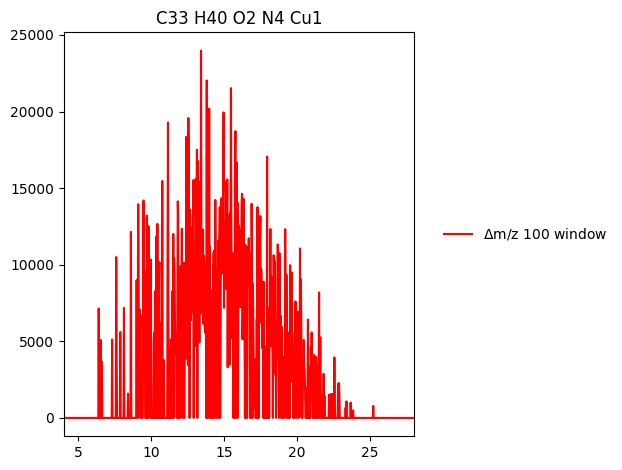

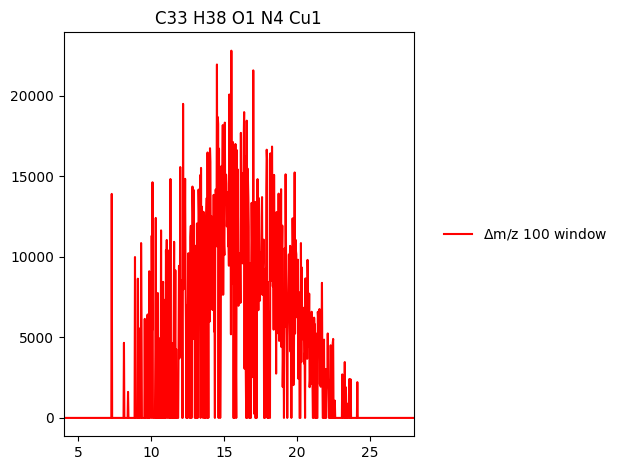

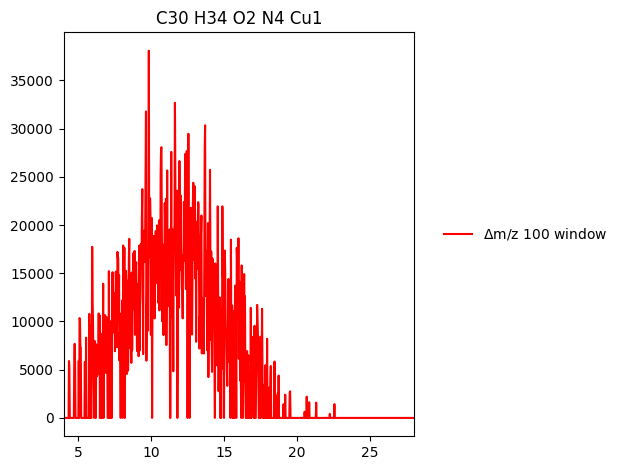

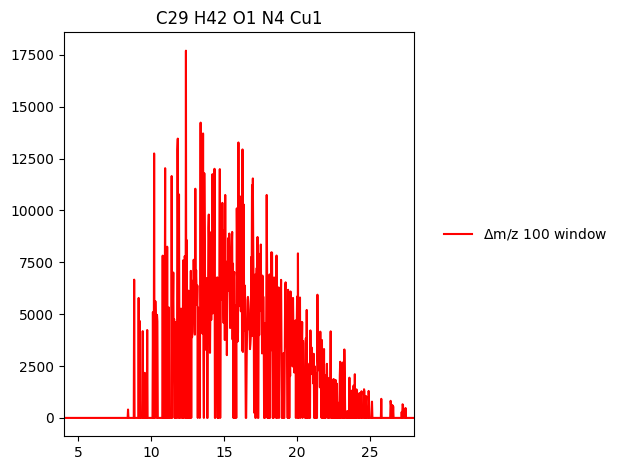

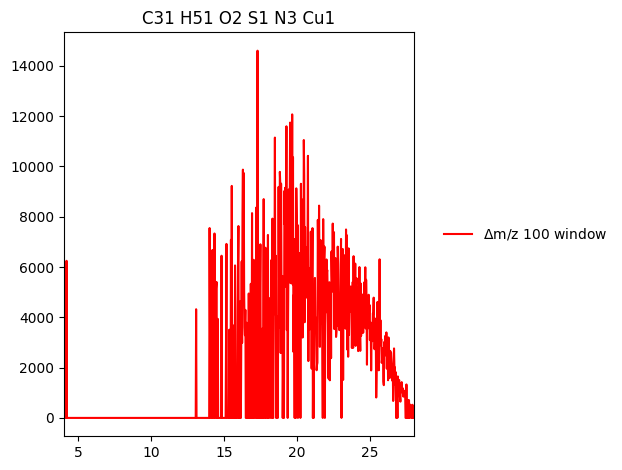

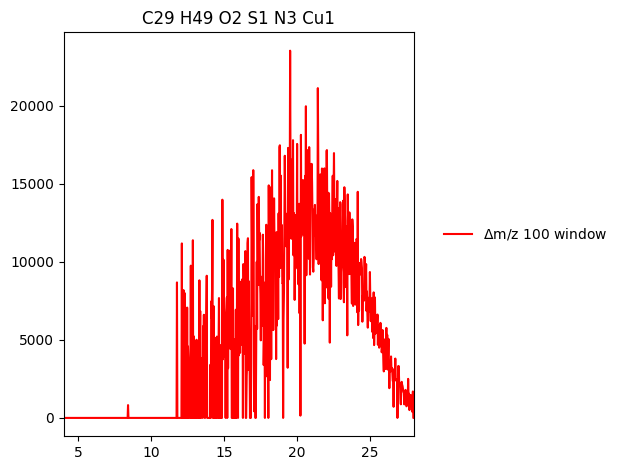

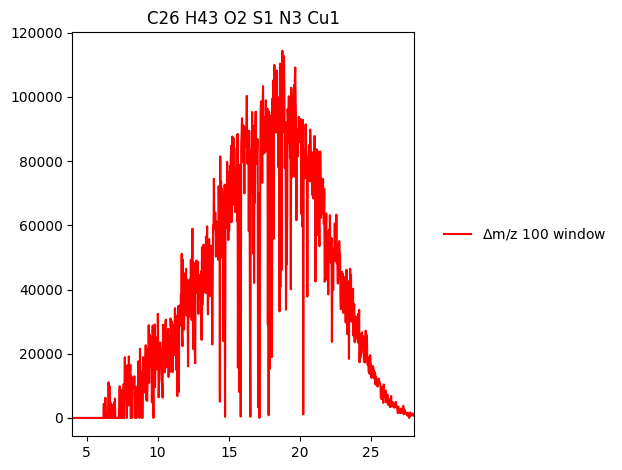

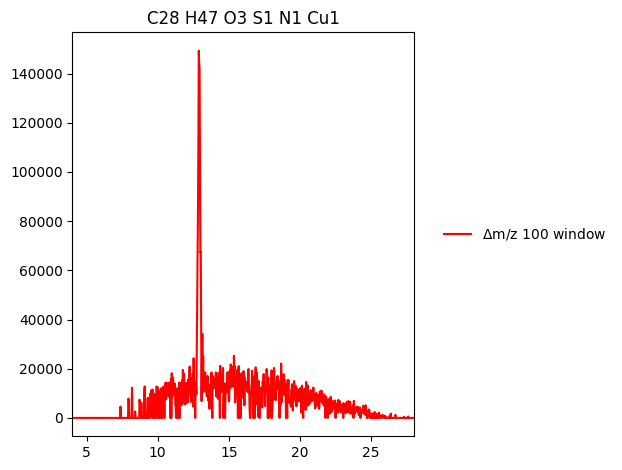

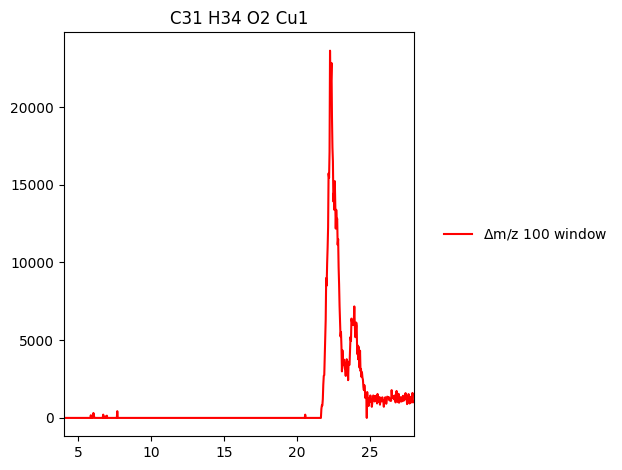

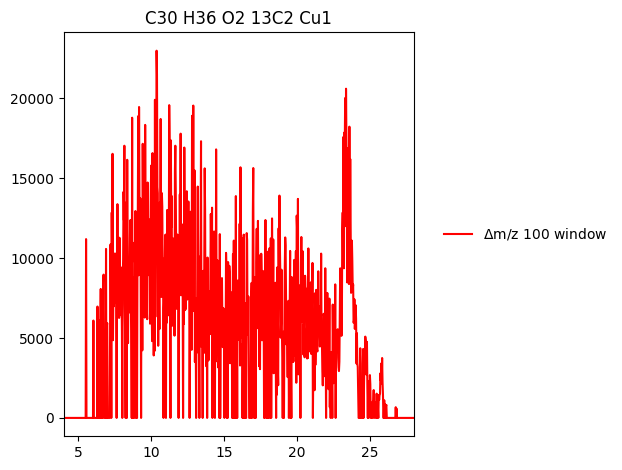

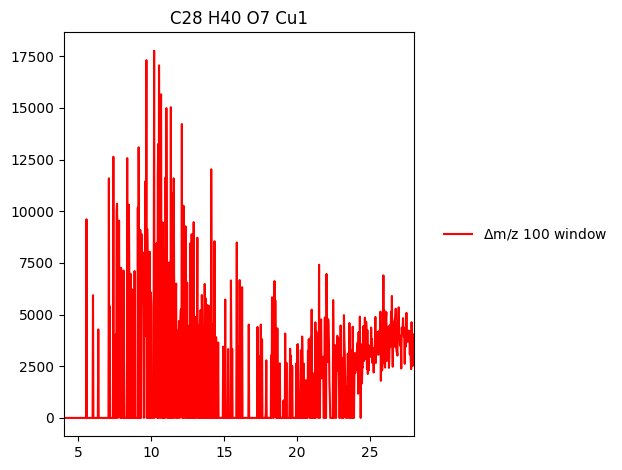

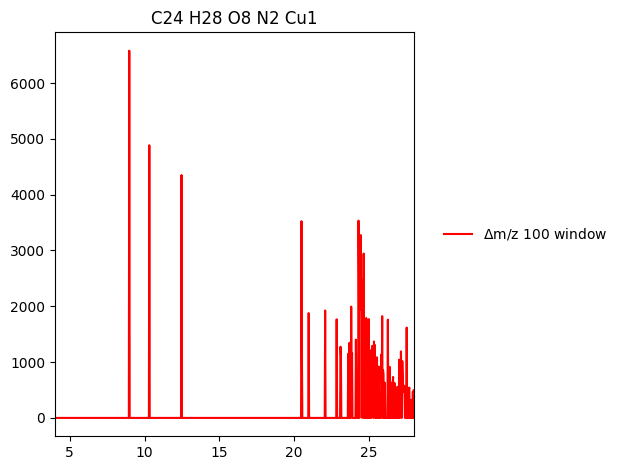

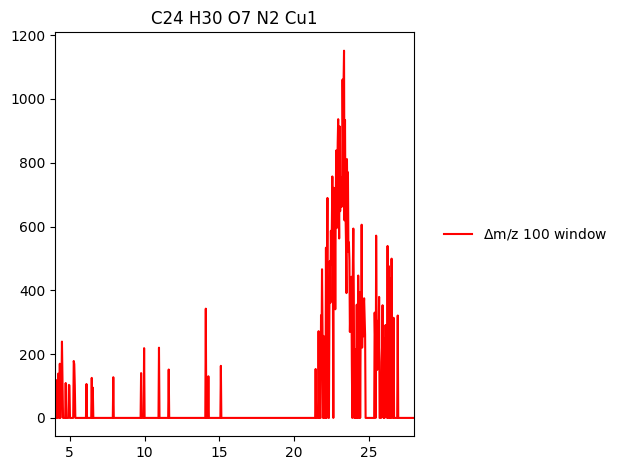

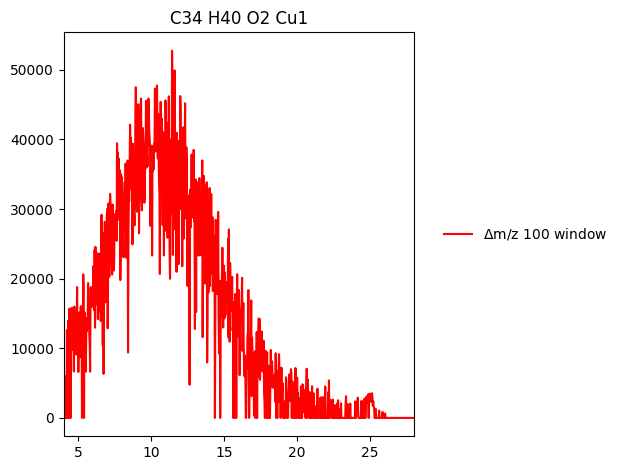

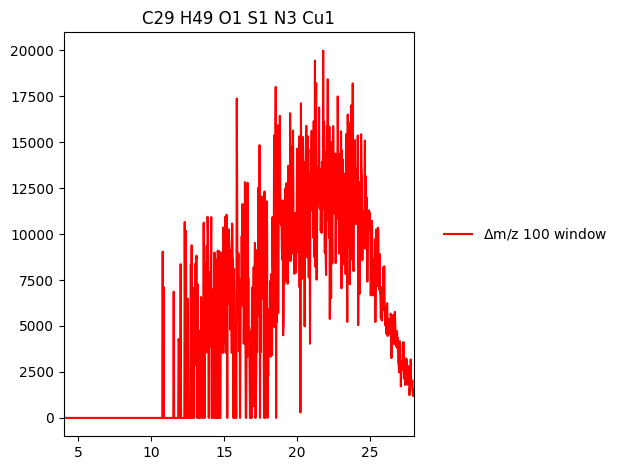

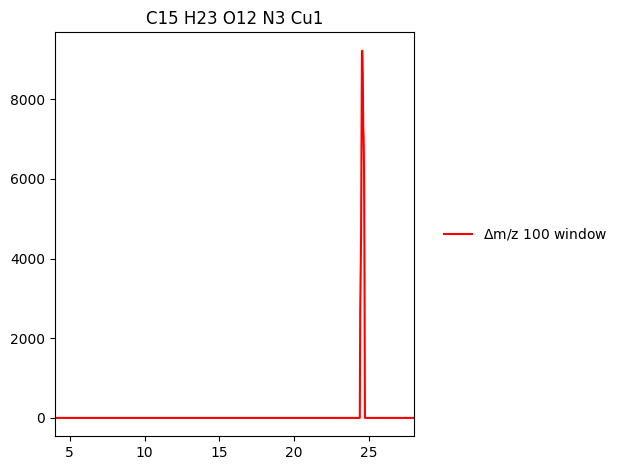

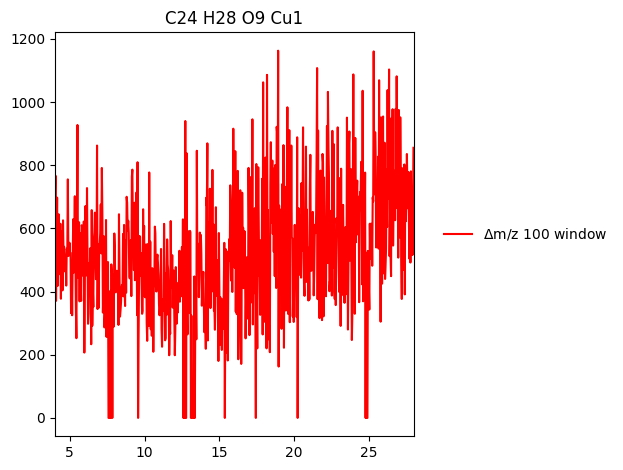

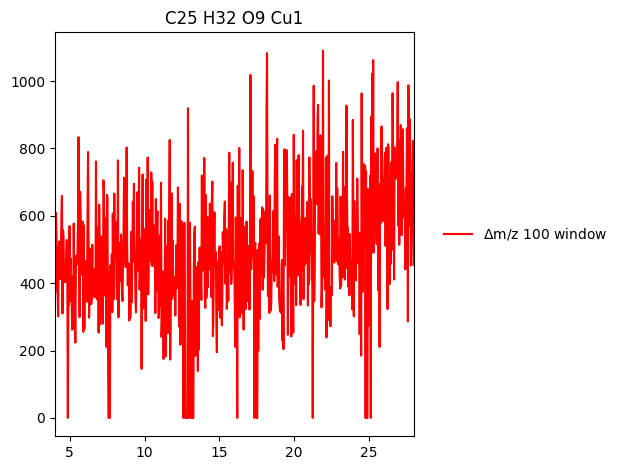

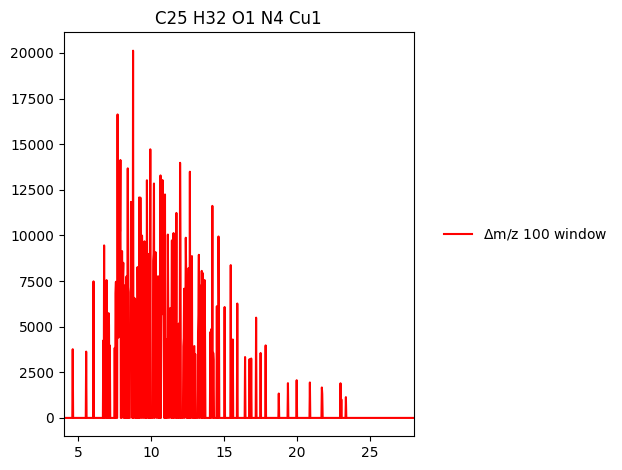

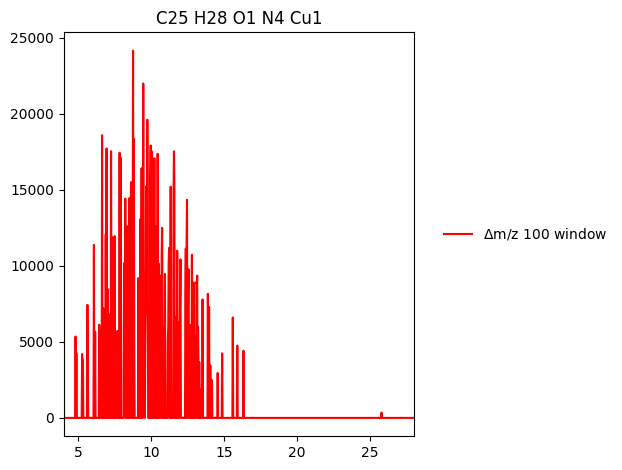

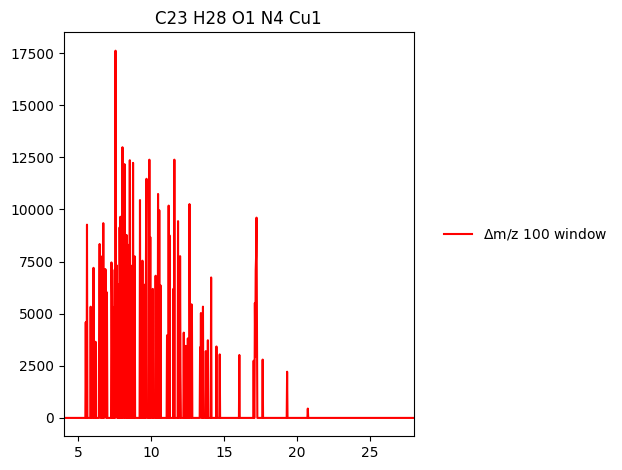

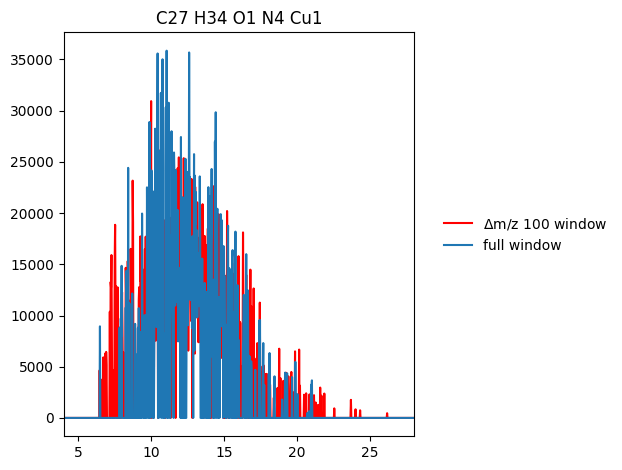

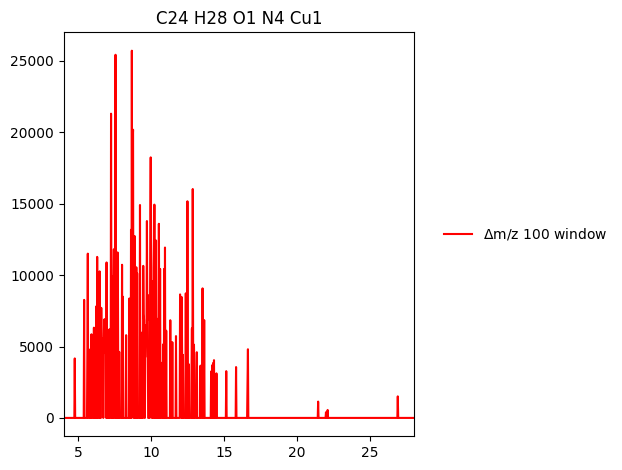

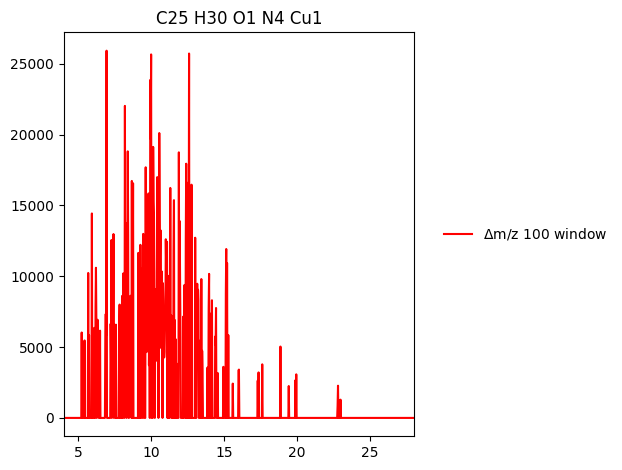

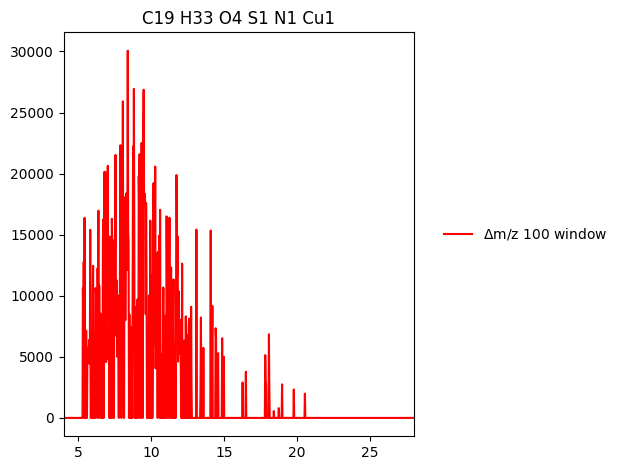

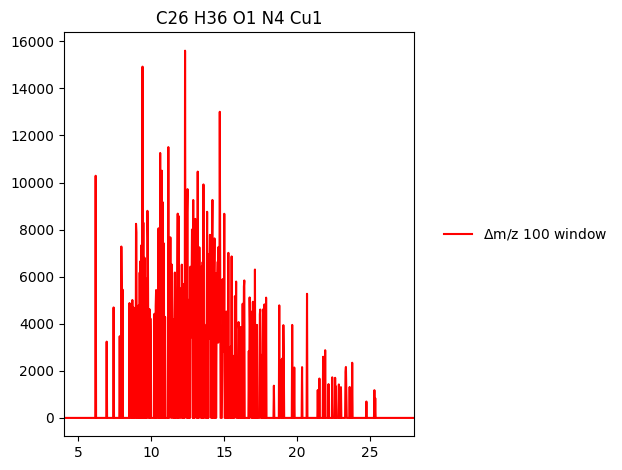

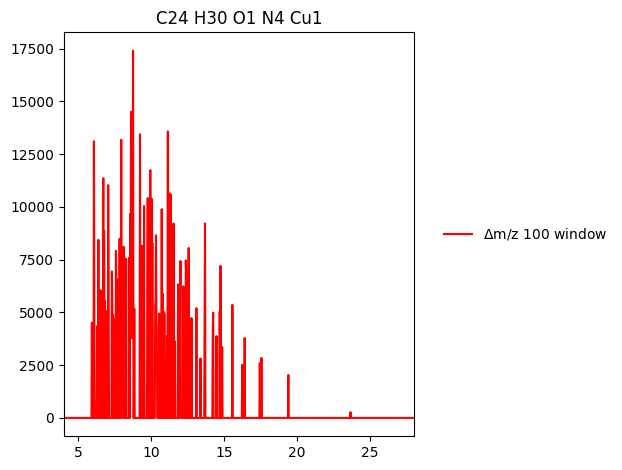

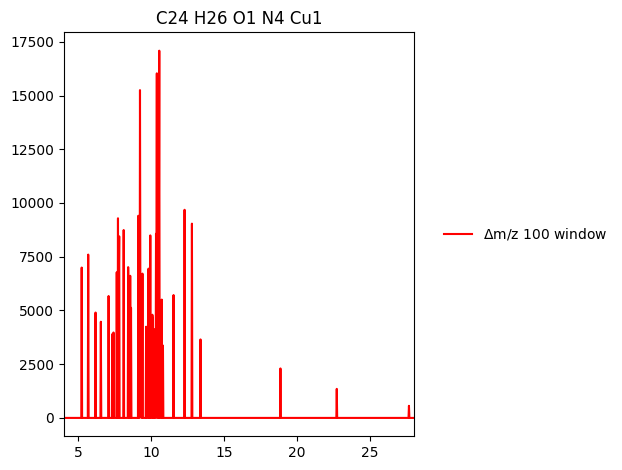

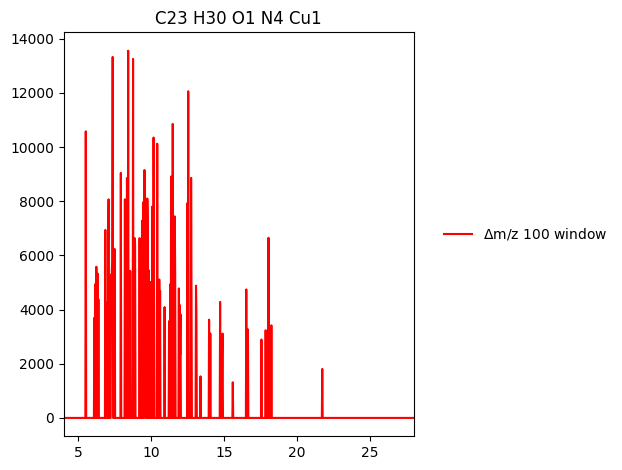

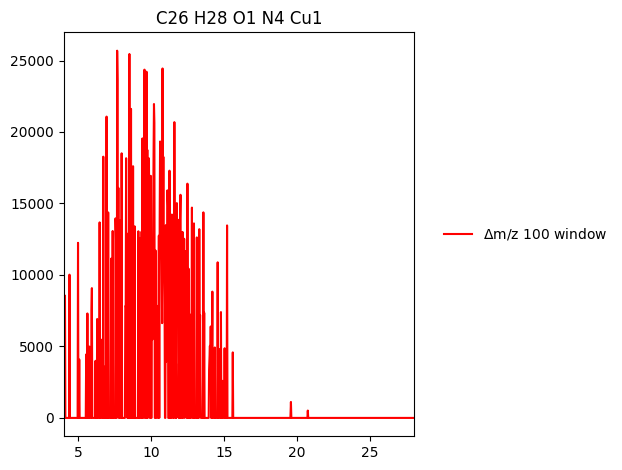

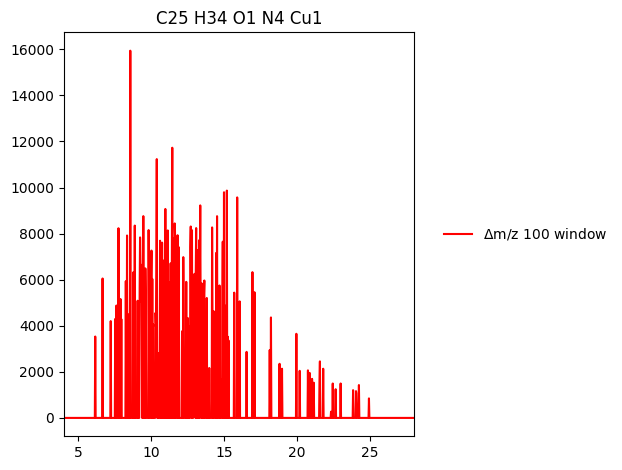

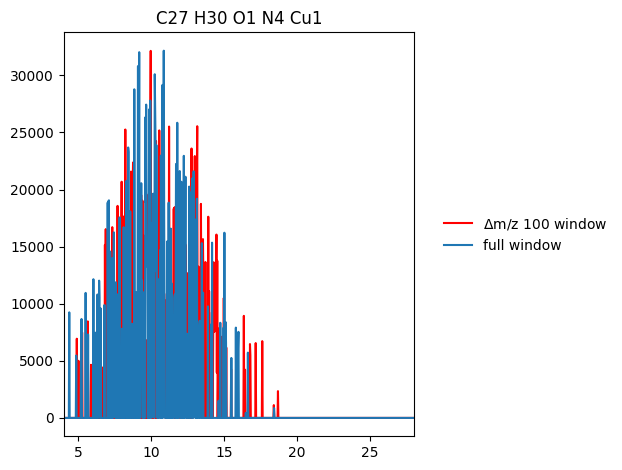

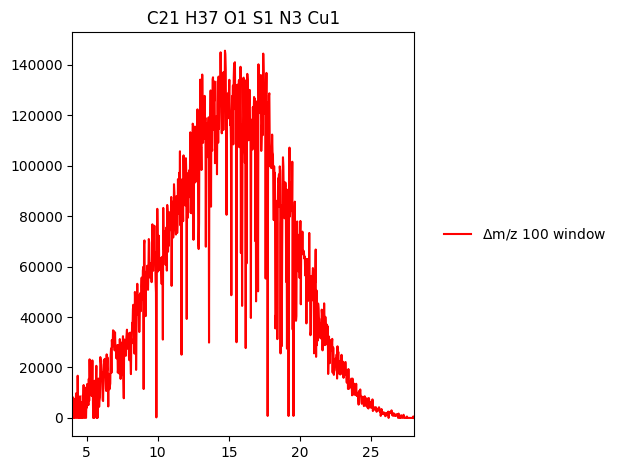

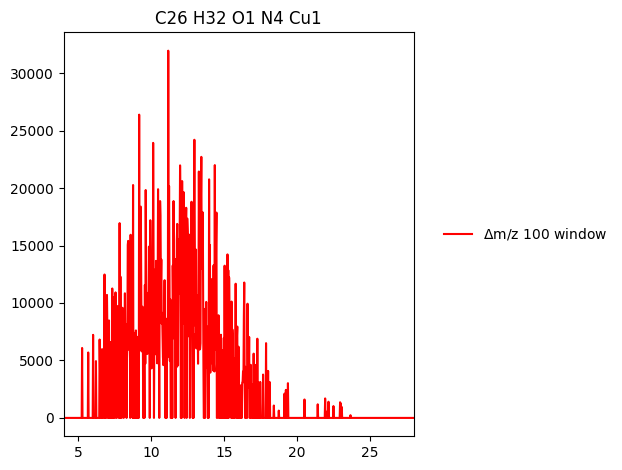

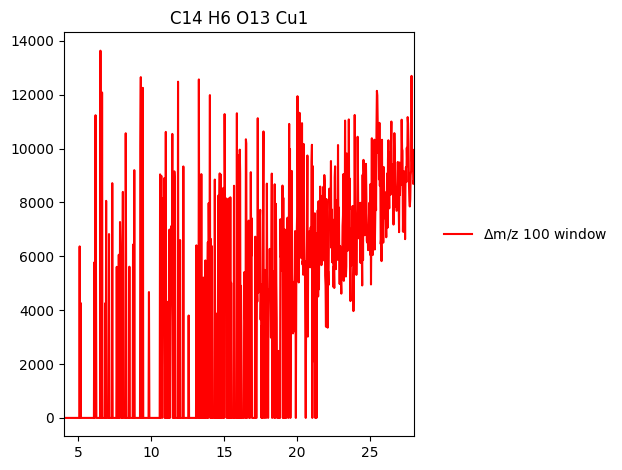

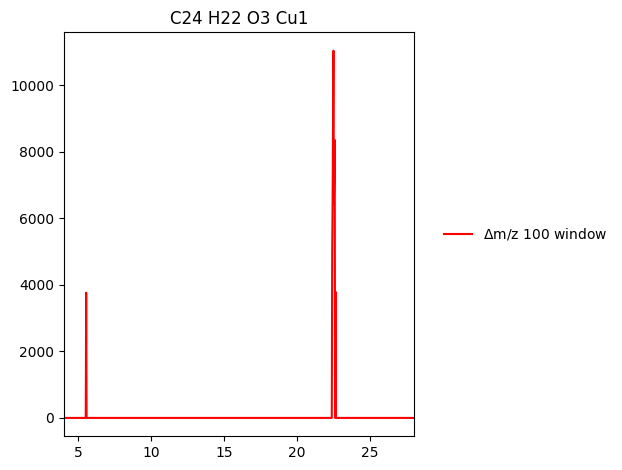

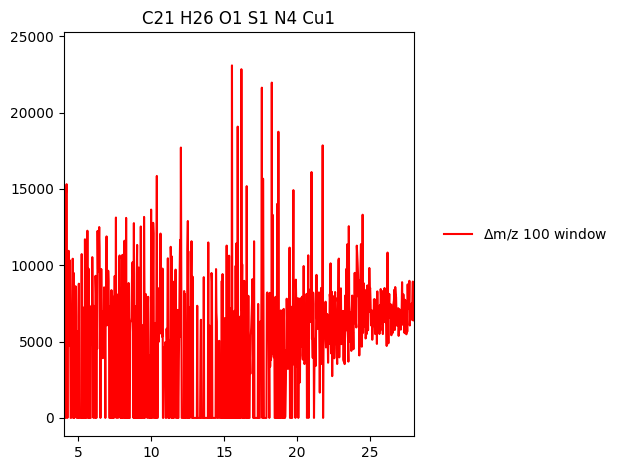

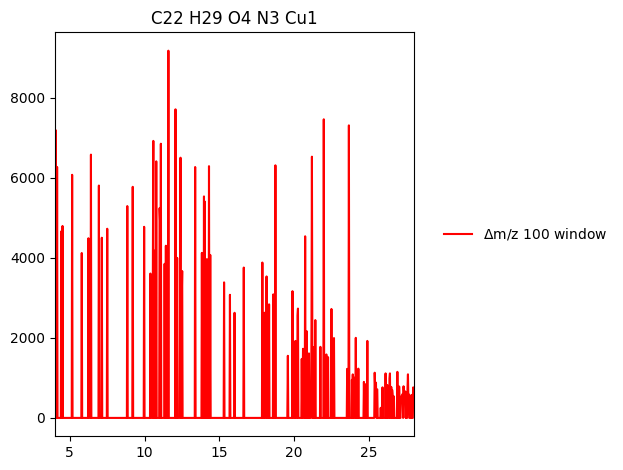

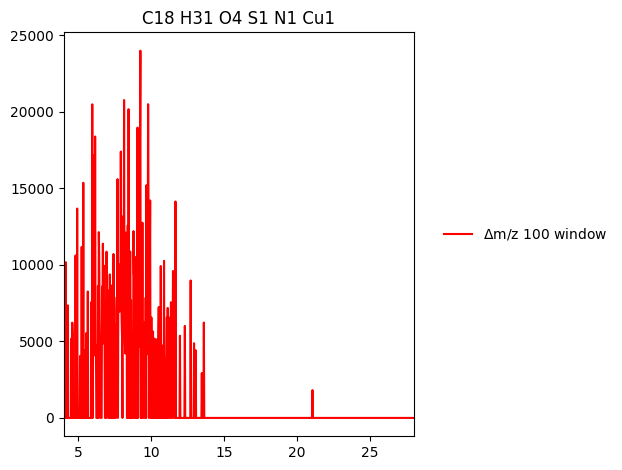

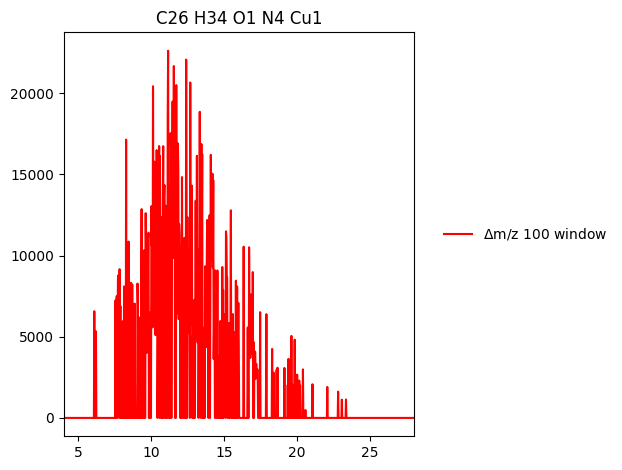

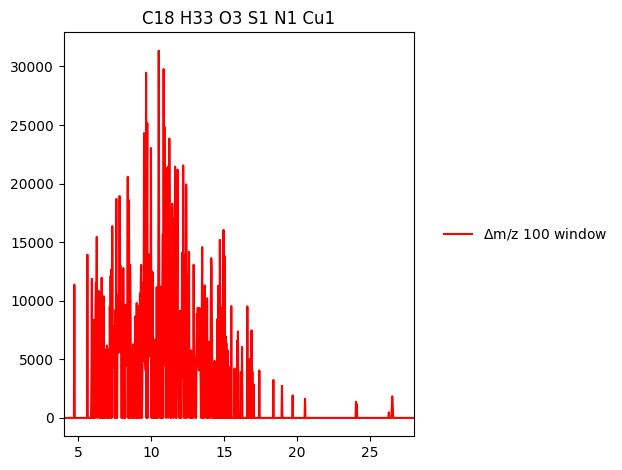

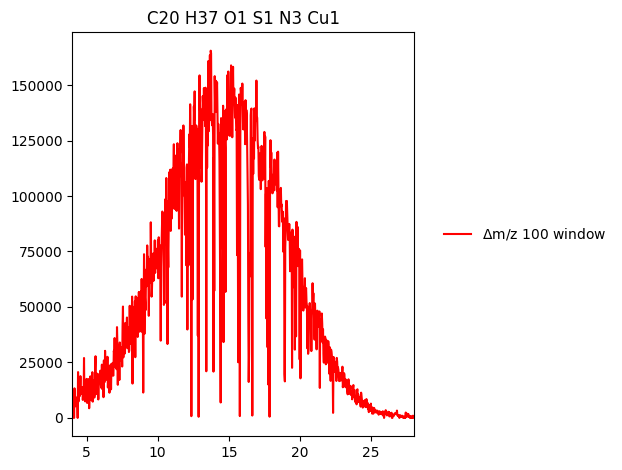

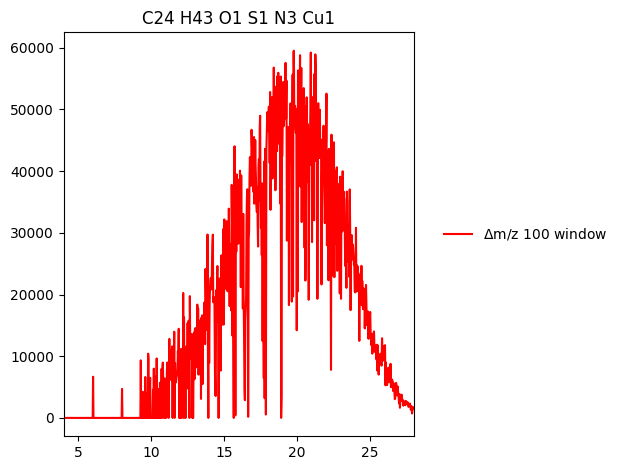

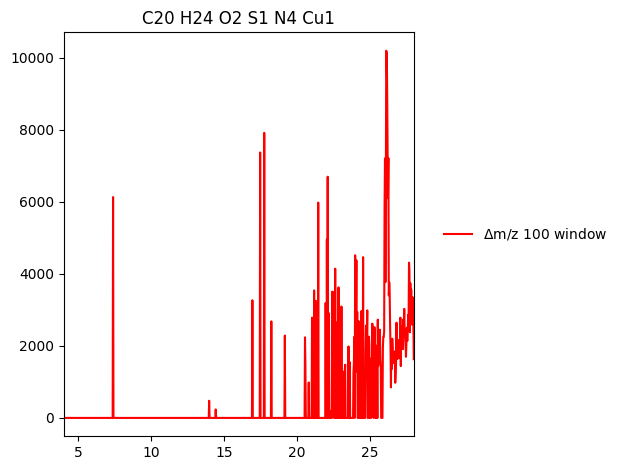

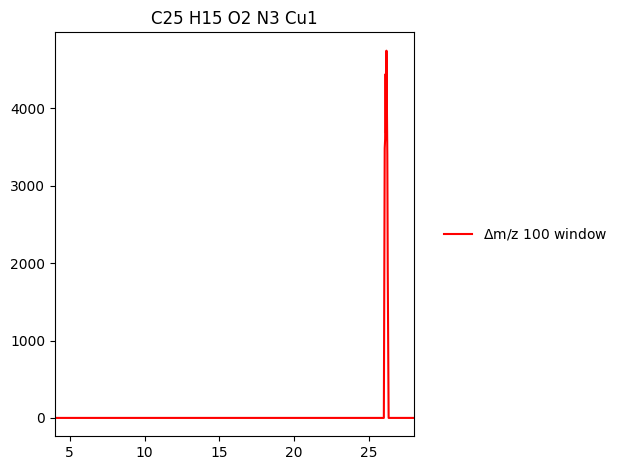

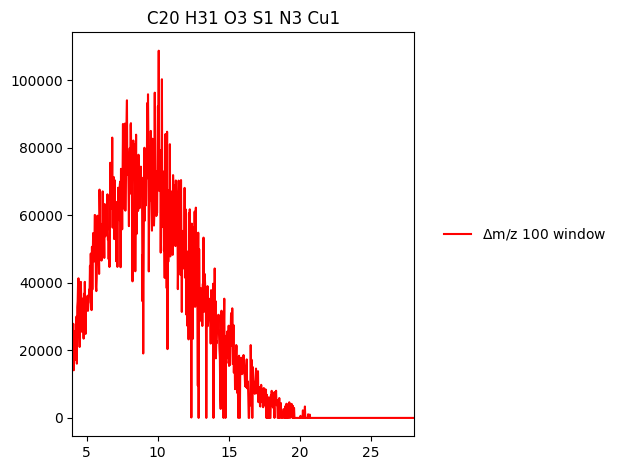

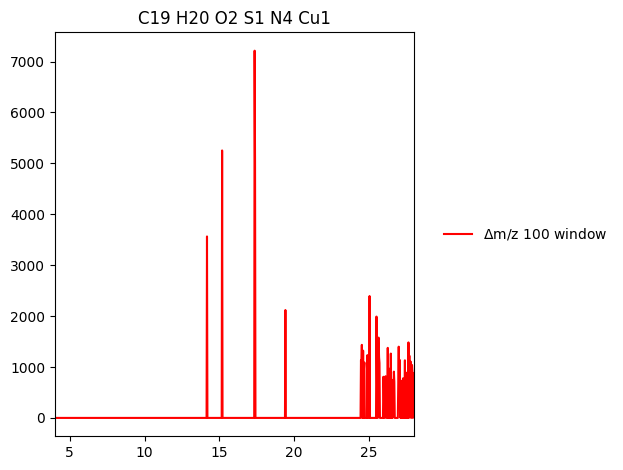

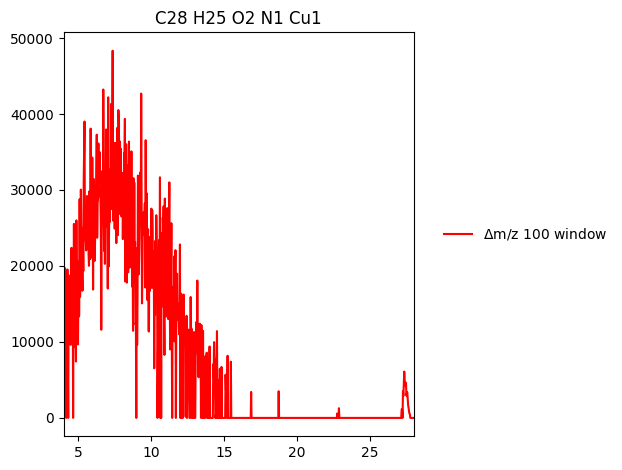

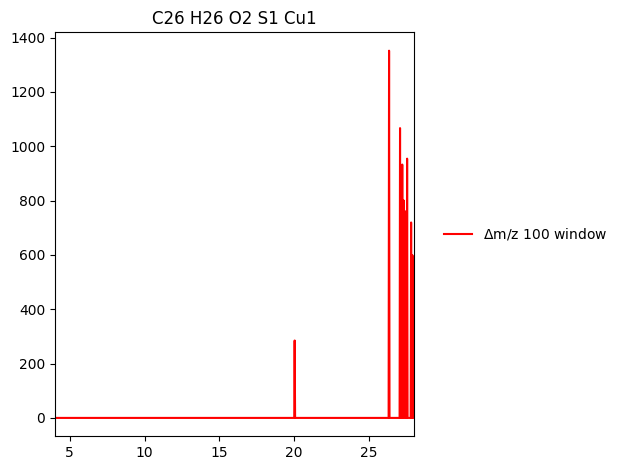

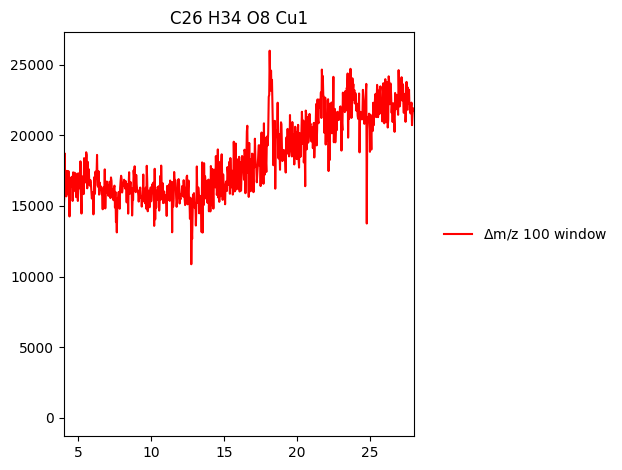

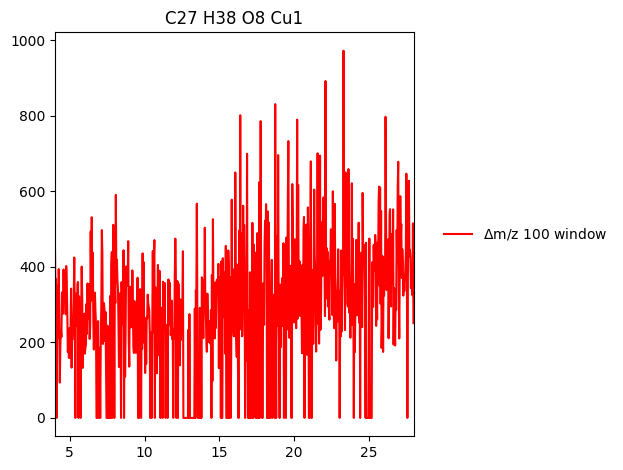

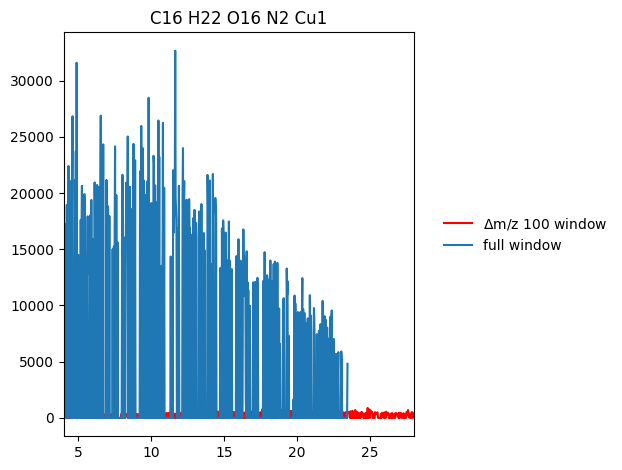

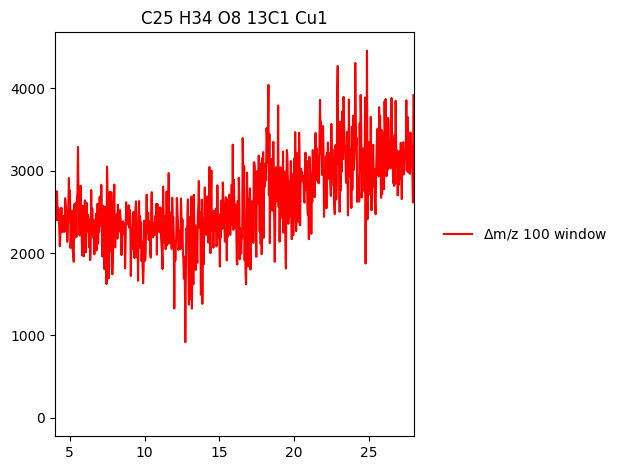

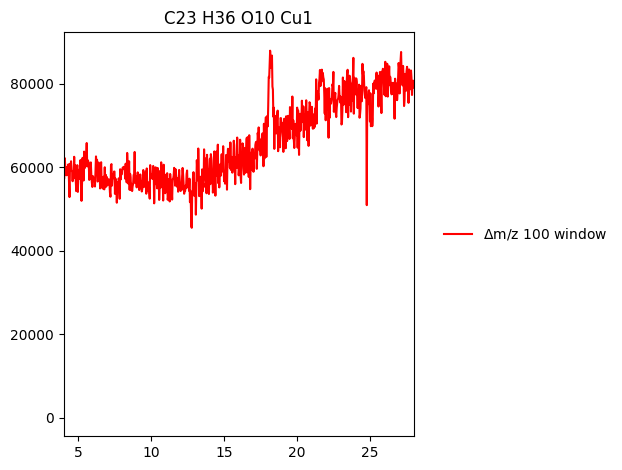

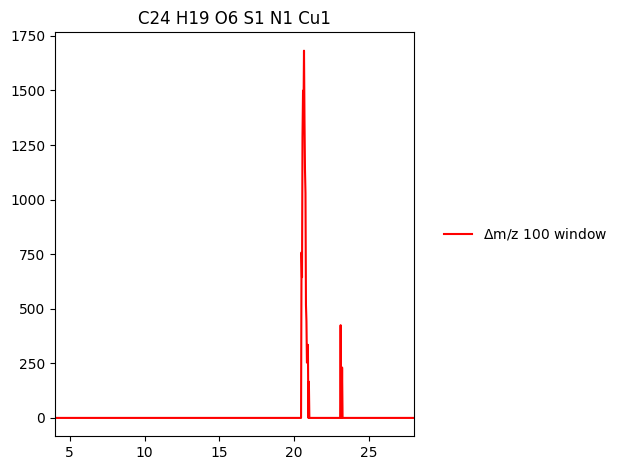

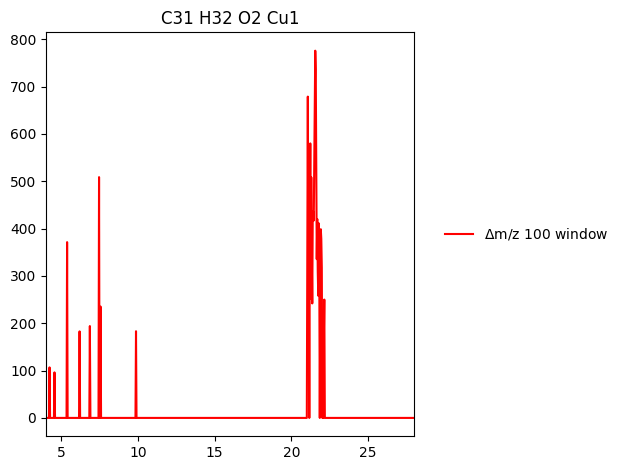

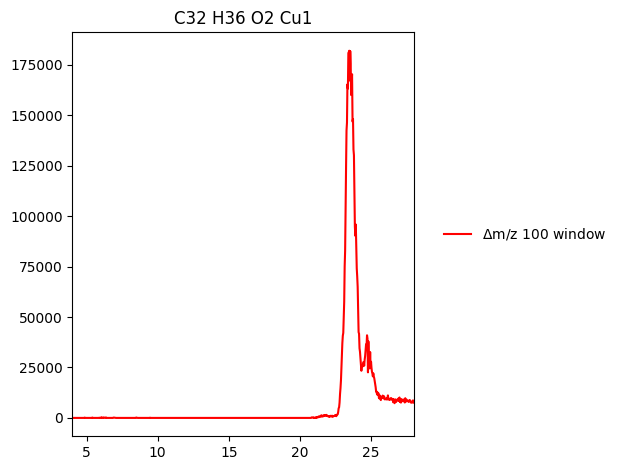

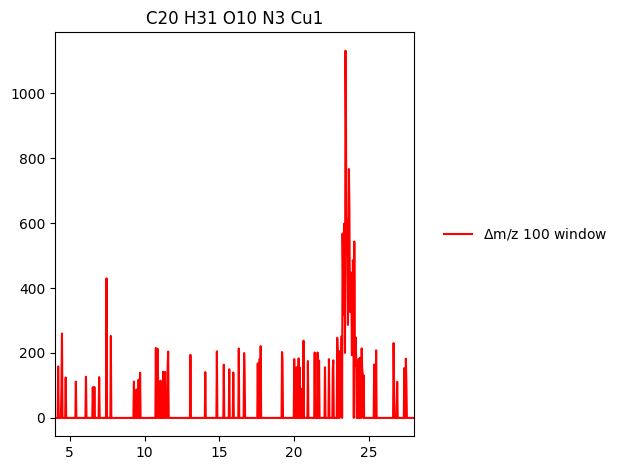

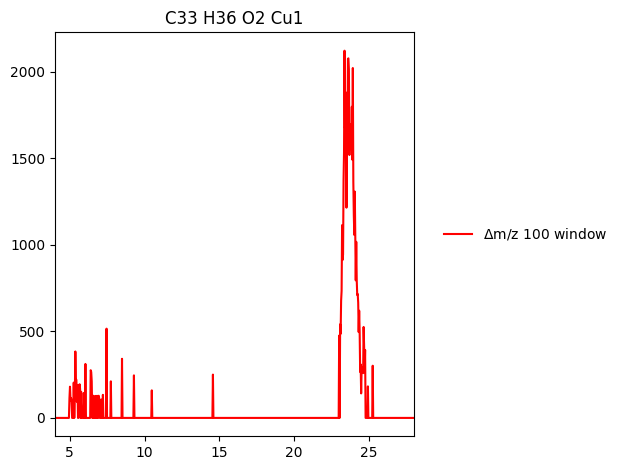

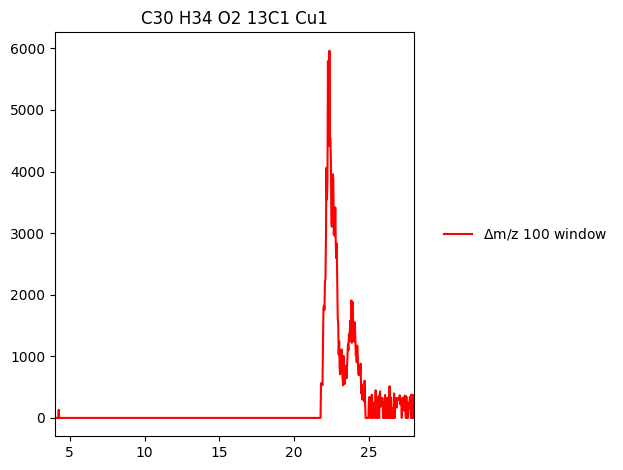

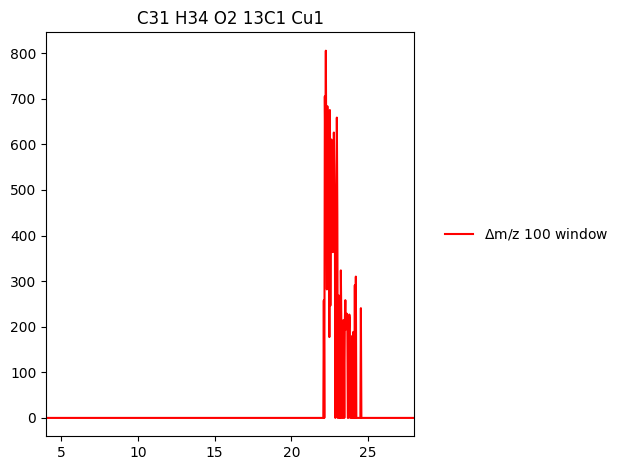

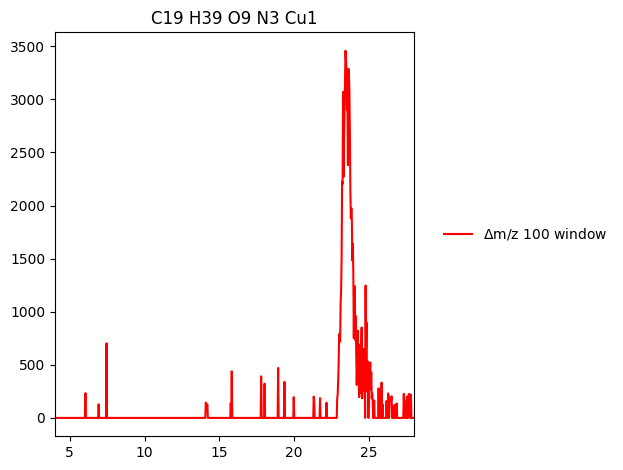

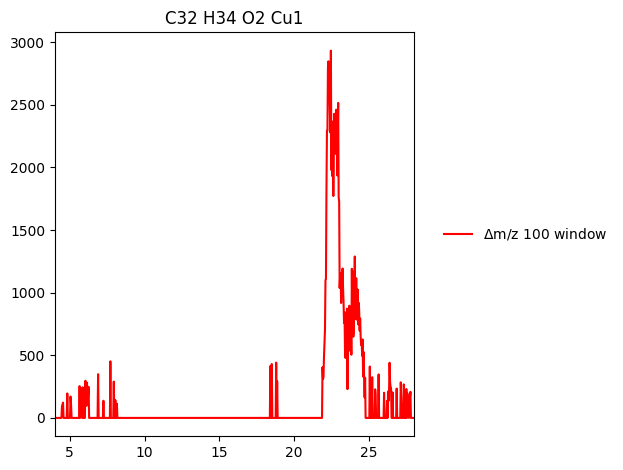

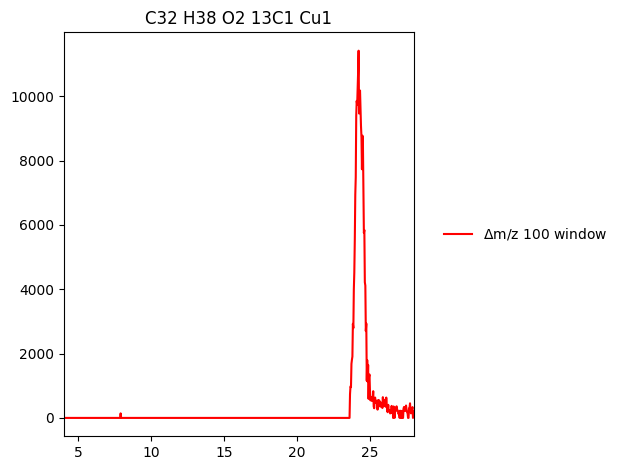

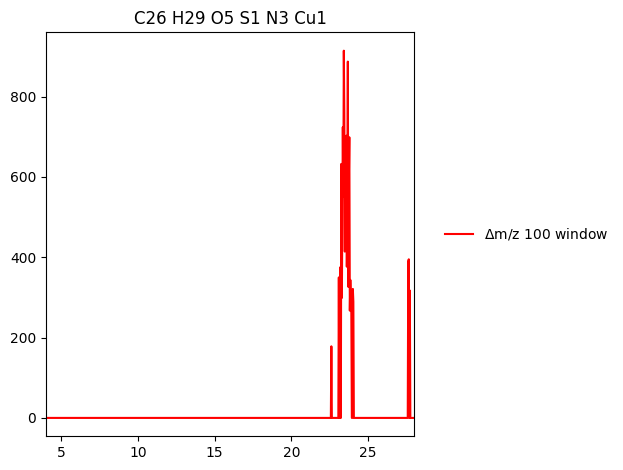

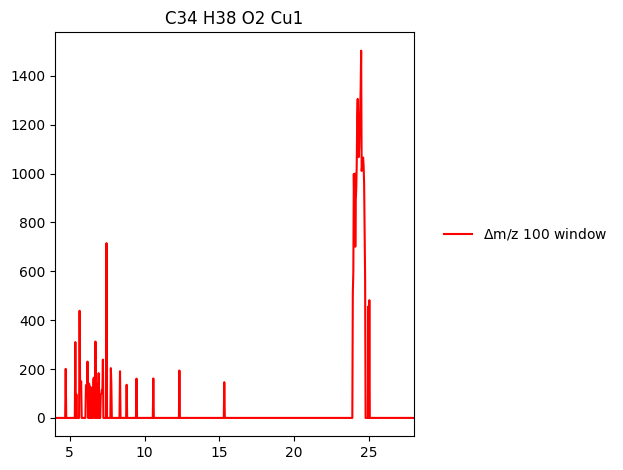

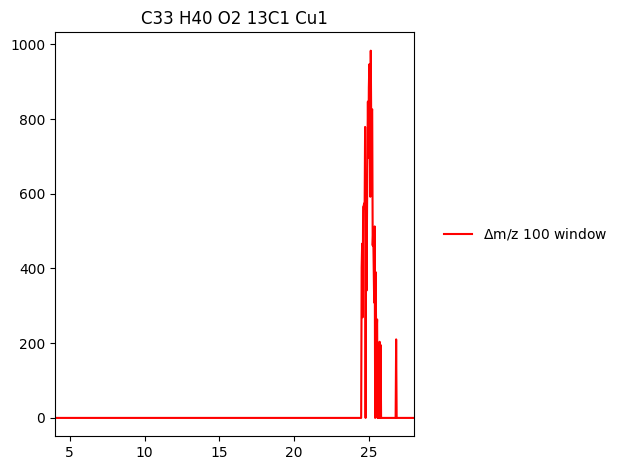

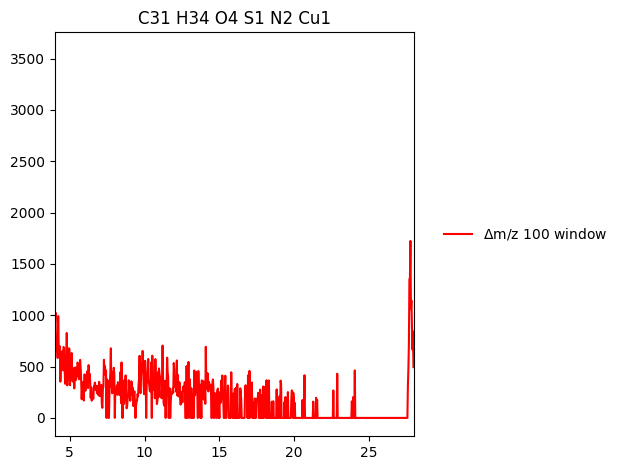

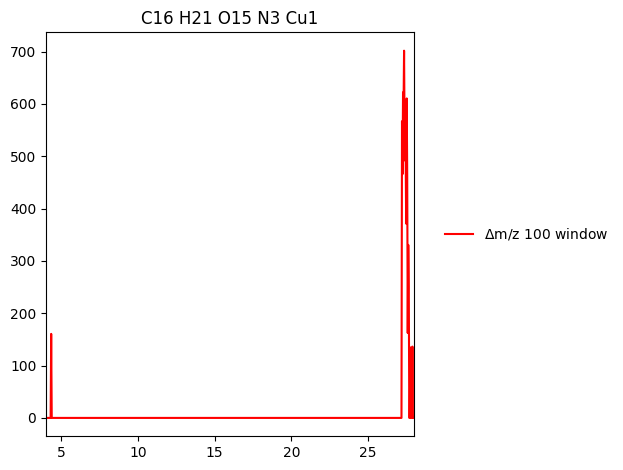

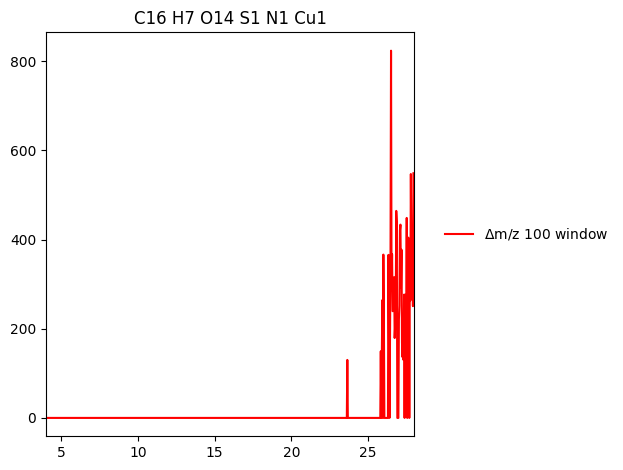

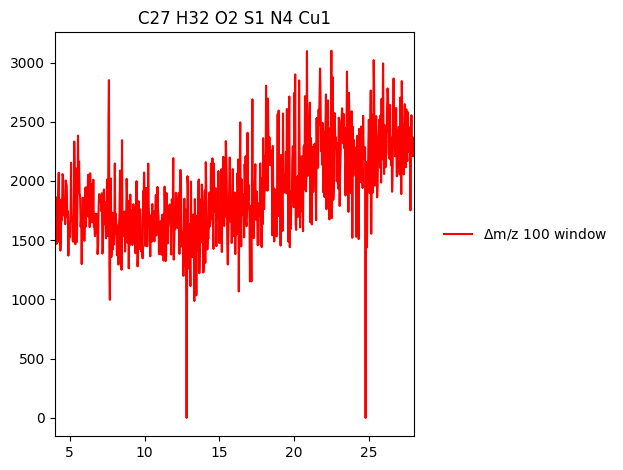

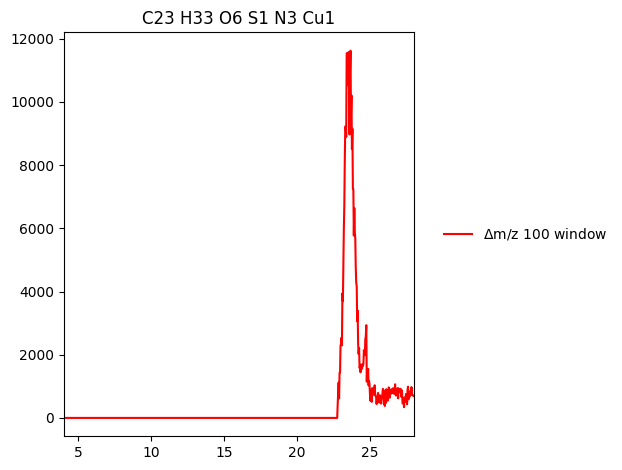

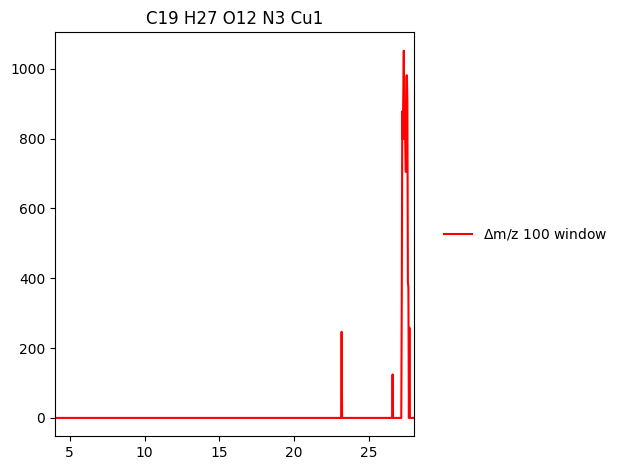

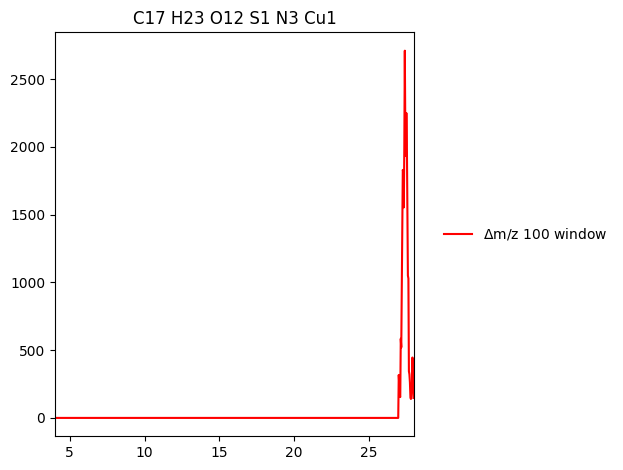

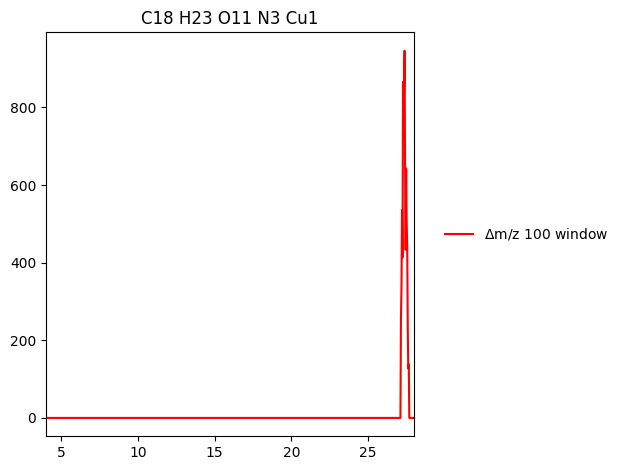

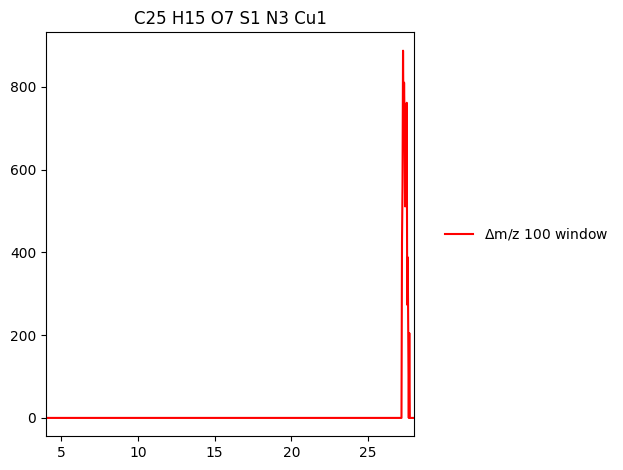

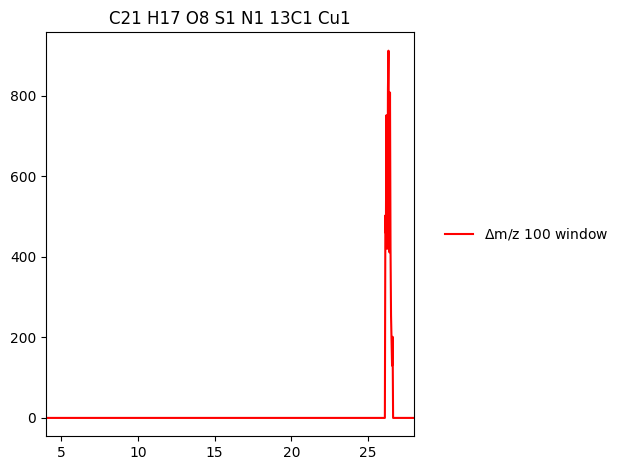

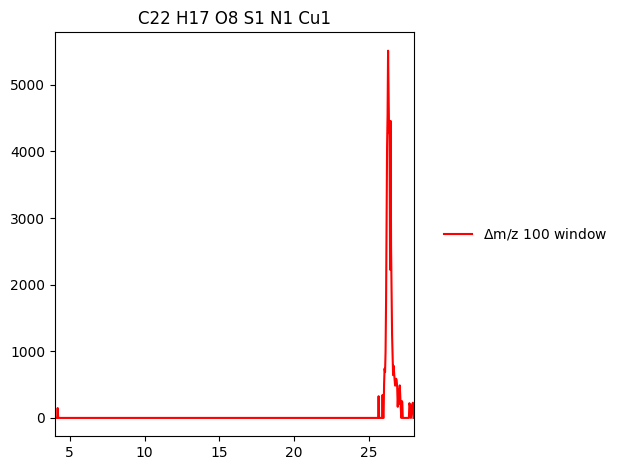

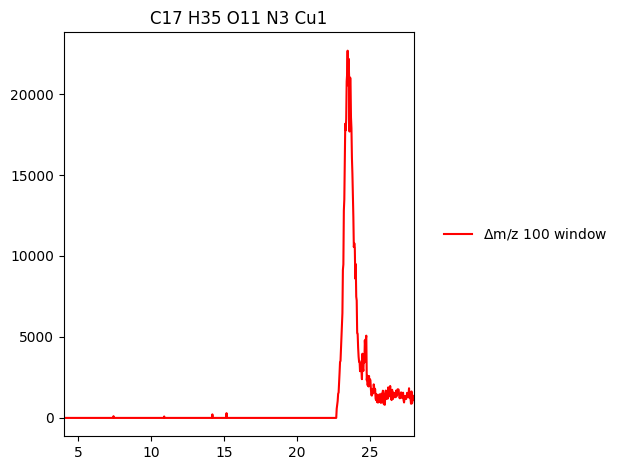

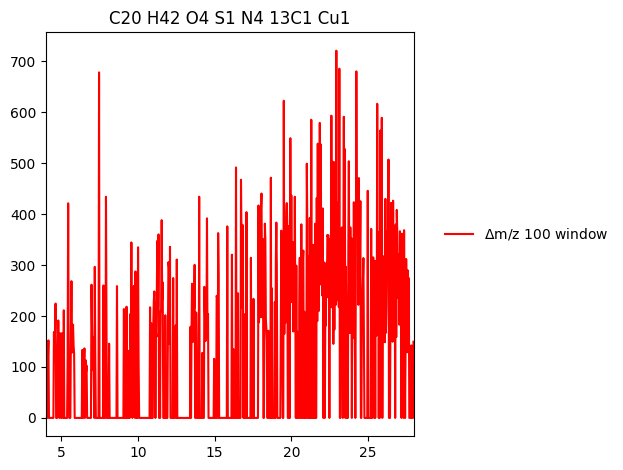

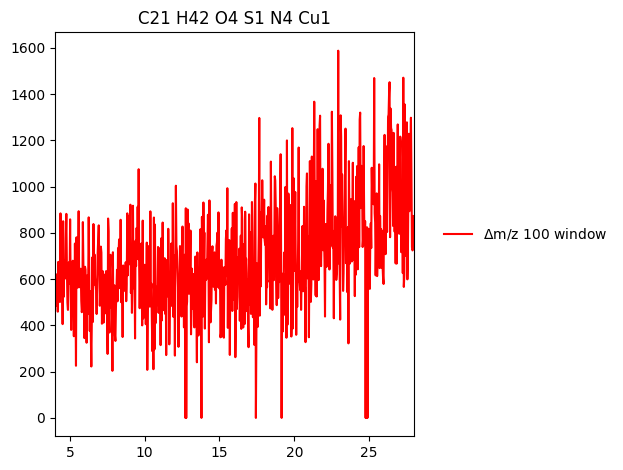

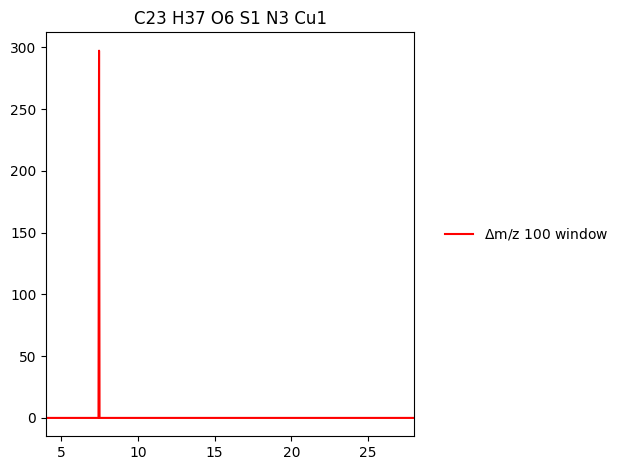

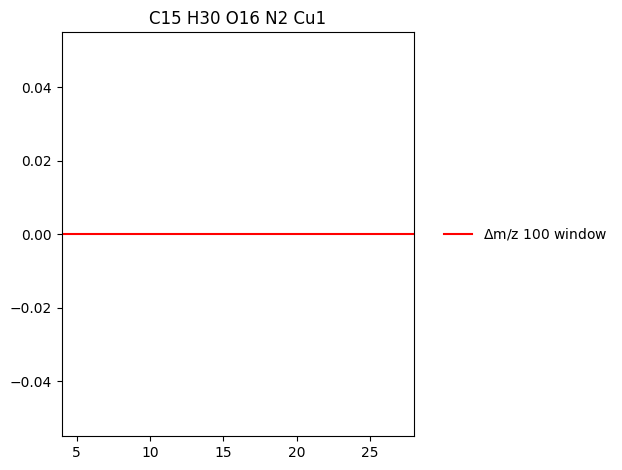

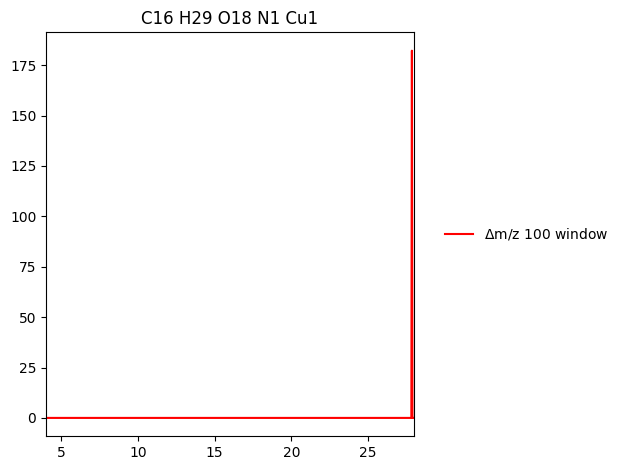

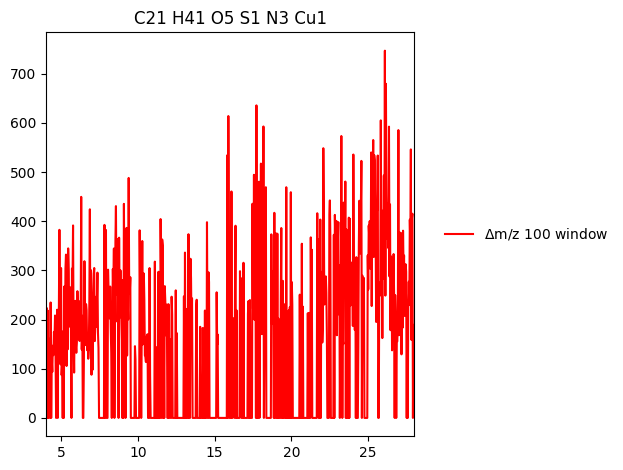

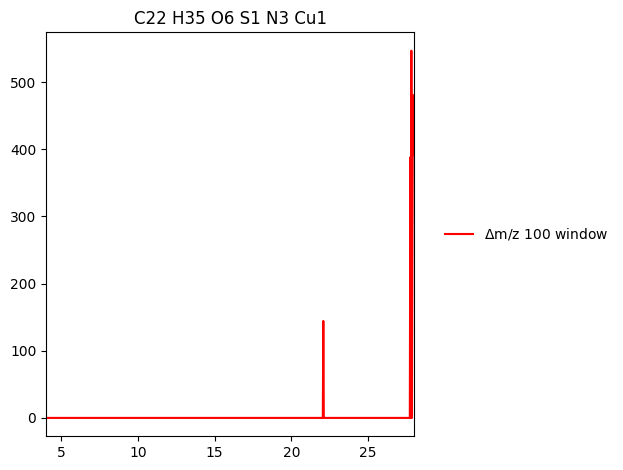

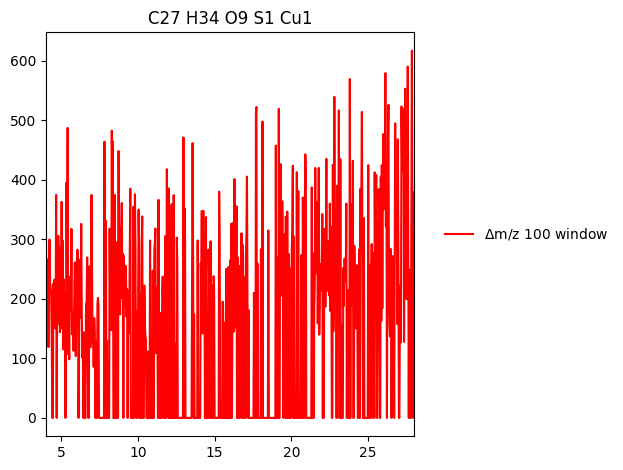

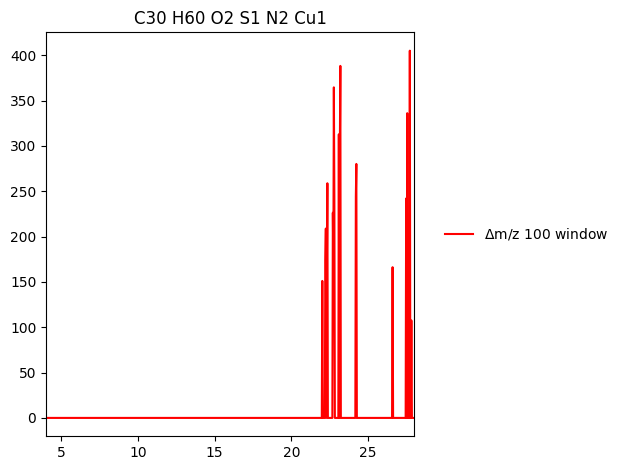

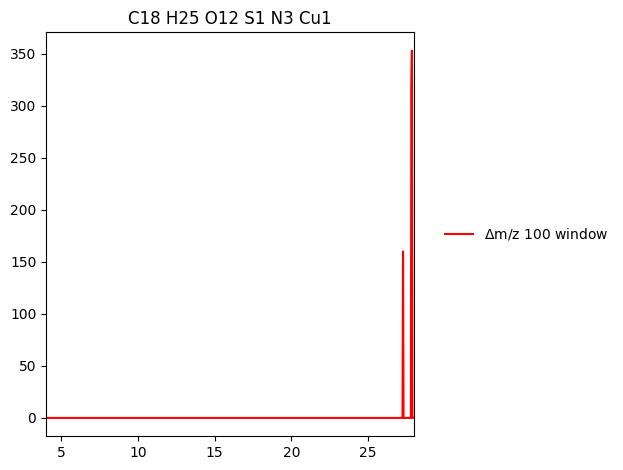

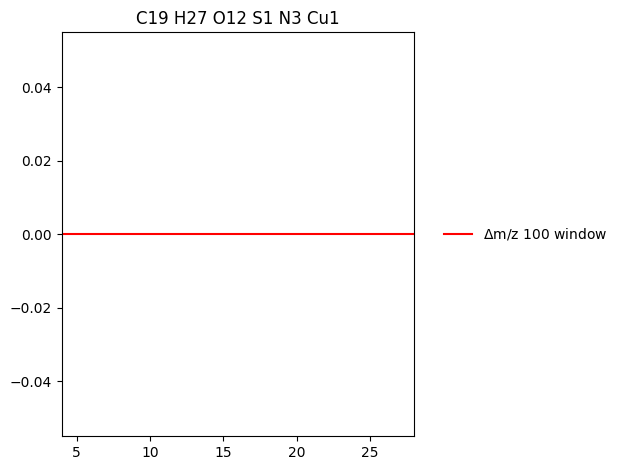

In [47]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_ENV.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu', '115In']

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_s_100mz_fullmz.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

pdf.close()

In [150]:
inds = np.where(np.asarray(mz100_EICdic[mf].time)<28)

np.asarray(mz100_EICdic[mf].time)[inds]

array([5.17500000e-03, 1.57000000e-02, 5.18683333e-02, 8.80150000e-02,
       1.24130000e-01, 1.60268333e-01, 1.96418333e-01, 2.32550000e-01,
       2.68705000e-01, 3.04830000e-01, 3.40980000e-01, 3.77120000e-01,
       4.13255000e-01, 4.49393333e-01, 4.85538333e-01, 5.21685000e-01,
       5.57823333e-01, 5.93956667e-01, 6.30096667e-01, 6.66235000e-01,
       7.02375000e-01, 7.38525000e-01, 7.74665000e-01, 8.10800000e-01,
       8.46935000e-01, 8.83078333e-01, 9.19225000e-01, 9.55358333e-01,
       9.91496667e-01, 1.02764833e+00, 1.06377667e+00, 1.09992500e+00,
       1.13605667e+00, 1.17219667e+00, 1.20833833e+00, 1.24448667e+00,
       1.28063667e+00, 1.31676000e+00, 1.35290333e+00, 1.38904167e+00,
       1.42518667e+00, 1.46133167e+00, 1.49747000e+00, 1.53361833e+00,
       1.56974667e+00, 1.60503833e+00, 1.64118833e+00, 1.67733167e+00,
       1.71346167e+00, 1.74960333e+00, 1.78546833e+00, 1.82161833e+00,
       1.85759833e+00, 1.89238000e+00, 1.92852000e+00, 1.96389667e+00,
      

In [45]:

def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    

def plot_ms(df1, start_mz, end_mz, tstart, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    if ax_ms == None:
        f, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz
    ms_t_int=df1[df1['Time'] == tstart]
    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        lbls = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if df2 is not None:
        ms_t_int2=df2[df2['Time'] == tstart]
        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])

    if df3 is not None:
        ms_t_int3=df3[df3['Time'] == tstart]
        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    
    if df3 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif df2 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if df2 is not None:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if df3 is not None:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms == None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub


def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    #ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax

def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    #filtered_results['S']=filtered_results['S'].fillna(0)
    #filtered_results['P']=filtered_results['Fe'].fillna(0)
    filtered_results['Cu']=filtered_results['Cu'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Fe']>0.5)]='CHOFe'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5)]='CHOCu'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['N']>0.5)]='CHONCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Cu']>0.5) & (filtered_results['S']>0.5)]='CHOSCu'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results #[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['N/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results
